In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [2]:
# user input
user_input = 'Restaurants'


# read in business file, compose business categories, business rating on category and business postal code dictionary

In [ ]:
# initialize business data
bcmap = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        state = l['state']
        #Business Category Dictionary
        category = l['categories']
        if state not in bcmap:
            bcmap[state] = {}
        bcmap[state][key] = category

# generate top categories
category = {}
for state in bcmap:
    category[state] = {}
    for i in bcmap[state]:
        if user_input in bcmap[state][i]:
            for j in bcmap[state][i]:
                if j not in category[state]:
                    category[state][j] = 1
                else:
                    category[state][j] += 1

tc = {}
for state in category:
    top_cate = sorted(category[state].items(), key=lambda x:(-x[1]))[1:21]
    tc[state] = []
    for i in top_cate:
        tc[state].append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['state']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if city not in bcrmap:
            bcrmap[city] = {}
        if key not in bcrmap[city]:
            bcrmap[city][key] = {}
        for i in category:
            if i in tc[city]:
                number_of_tc += 1
                valid = True
                bcrmap[city][key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[city][key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [ ]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        
        okey = n1['user_id']
        year = n1['date']
        bid = n1['business_id']
        value = n1['stars']
        
        
        city = location[bid]
        ikeys = bcmap[city][bid]
        
        
        if city not in user_rating:
            user_rating[city] = {}
        user_rating[city].setdefault(okey, []).append(value)
        if city not in ucrmap:
            ucrmap[city]  = {}
        if city not in test_urcmap:
            test_urcmap[city]  = {}
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap[city]:
                ucrmap[city][okey] = {}
            for ikey in ikeys:
                if ikey in tc[city]:
                    ucrmap[city][okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[city][okey] = {}
            test_urcmap[city][okey][bid] = value

In [ ]:
listCity = {}
for i in ucrmap:
    if i in bcrmap:
        listCity[i] = {}
        listCity[i]['user'] = len(ucrmap[i])
        listCity[i]['business'] = len(bcrmap[i])

In [ ]:
len(listCity)

51

In [ ]:
sorted_by_business = sorted(listCity.items(), key=lambda x: -x[1]['business'])
sorted_by_business[:15]

[('AZ', {'business': 3018, 'user': 227835}),
 ('ON', {'business': 2244, 'user': 67838}),
 ('NV', {'business': 1708, 'user': 307931}),
 ('OH', {'business': 1591, 'user': 40599}),
 ('NC', {'business': 1174, 'user': 47382}),
 ('PA', {'business': 1130, 'user': 37990}),
 ('QC', {'business': 779, 'user': 23852}),
 ('EDH', {'business': 671, 'user': 6766}),
 ('BW', {'business': 623, 'user': 10648}),
 ('WI', {'business': 529, 'user': 19821}),
 ('IL', {'business': 152, 'user': 7774}),
 ('SC', {'business': 70, 'user': 2966}),
 ('HLD', {'business': 30, 'user': 448}),
 ('MLN', {'business': 27, 'user': 756}),
 ('FIF', {'business': 25, 'user': 186})]

In [ ]:
sorted_by_user = sorted(listCity.items(), key=lambda x: -x[1]['user'])
sorted_by_user[:15]

[('NV', {'business': 1708, 'user': 307931}),
 ('AZ', {'business': 3018, 'user': 227835}),
 ('ON', {'business': 2244, 'user': 67838}),
 ('NC', {'business': 1174, 'user': 47382}),
 ('OH', {'business': 1591, 'user': 40599}),
 ('PA', {'business': 1130, 'user': 37990}),
 ('QC', {'business': 779, 'user': 23852}),
 ('WI', {'business': 529, 'user': 19821}),
 ('BW', {'business': 623, 'user': 10648}),
 ('IL', {'business': 152, 'user': 7774}),
 ('EDH', {'business': 671, 'user': 6766}),
 ('SC', {'business': 70, 'user': 2966}),
 ('MLN', {'business': 27, 'user': 756}),
 ('HLD', {'business': 30, 'user': 448}),
 ('FL', {'business': 0, 'user': 349})]

In [ ]:
def recommend_based_on_state(state):
    print('============================================')
    print('Recommendation info summary for : ', state)

    City_of_Data = state
   
    # pre-process data: build up user and business data set based on state
    filter_user = {}
    valid_user = {}
    valid_test_user = {}
    for i in user_rating[City_of_Data]:
        if len(user_rating[City_of_Data][i]) >= 20:
            filter_user[i] = len(user_rating[City_of_Data][i])
    raw = sorted(filter_user.items(), key=lambda x:-x[1])
    valid_list = []
    for k, v in raw:
        if k in ucrmap[City_of_Data] and k in test_urcmap[City_of_Data]:
            valid_list.append(k)
            valid_user[k] = ucrmap[City_of_Data][k]
            valid_test_user[k] = test_urcmap[City_of_Data][k]
            
    print('number of valid user: ', len(valid_user))
    print('number of valid test user: ', len(valid_user))
    
    #generate business category dict with pure vector
    def generate_nbcrmap(data):
        for business in data:
            for k, v in data[business].items():
                data[business][k] = statistics.mean(v)

        for business in data:
            for i in tc[state]:
                if i not in data[business]:
                    data[business][i] = 3.15

        nbcrmap = {}
        for k, v in data.items():
            nbcrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nbcrmap[k] = value
        return nbcrmap

    nbcrmp = generate_nbcrmap(bcrmap[City_of_Data])
    
    # Compose user category vector
    def generate_nucrmap(data):
        for user in data:
            for cate, value in data[user].items():
                data[user][cate] = statistics.mean(value)
        for user in data:
            for i in tc[state]:
                if i not in data[user]:
                    data[user][i] = 3.15

        nucrmap = {}
        for k, v in data.items():
            nucrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nucrmap[k] = value
        return nucrmap

    nucrmap = generate_nucrmap(valid_user)
    
    data = nucrmap
    listV = list(data.values())
    listK = list(data.keys())
    
    # Agglomerative clustering using scipy
    Z = scipy.cluster.hierarchy.linkage(listV[:300], method='average')
    plt.clf()
    fig = plt.figure(figsize=(100, 60), dpi=40, facecolor='w', edgecolor='k')
    dd = scipy.cluster.hierarchy.dendrogram(Z)
    plt.savefig('{}.pdf'.format('average'))
    plt.show()
    
    
    #agglomerative clustering using sklearn 
    data1 = []
    for k,v in nucrmap.items():
        data1.append(v)
    np.save('123', np.array(data1))
    data1 = np.load('123.npy')

    # get number of clusters from above plot and generate clusters dictionary
    model = cluster.AgglomerativeClustering(linkage='average', n_clusters=20)
    result = model.fit_predict(listV)
    clusters = {}
    for i in range(len(result)):
        k = result[i]
        v = data1[i]
        clusters.setdefault(k, []).append(v)

    # Average Vector for each cluster generated above

    average_vector = {}
    for i in list(clusters.keys()):
        average_vector[i] = np.mean(clusters[i], axis=0)

    def generate_recommendatioin(uid):
        index = listK.index(uid)
        uvector = average_vector[result[index]]
        r = {}
        for i in nbcrmp:
            r[i] = np.inner(uvector, nbcrmp[i])
        top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
        return [k for k,v in top_business]
    def cacluate_hr(uid, bids):
        score = 0
        count = 0
        for bid in bids:
            if bid in valid_test_user[uid]:
                count += 1
                if valid_test_user[uid][bid] > 3.7:
                    score += 1
                if valid_test_user[uid][bid] < 2.6:
                    score -= 1
        return np.array([score, count])
    
    def calculate_ndcg(uid, bids):
        gain = 0
        ind_list = []
        for i in range(len(bids)):
            bid = bids[i]
            if bid in valid_test_user[uid]:
                ind_list.append(i+1)
                gain += valid_test_user[uid][bid]/(i+1)
        idcg = 0
        for i in ind_list:
            idcg += 5/i
        if idcg == 0:
            return 0
        return np.array([gain,idcg])

    def evaluate(list_test):
        hr = np.array([0.,0.])
        ndcg = np.array([0.,0.])
        for uid in list_test:
            recs = generate_recommendatioin(uid)
            tmp = cacluate_hr(uid, recs)
            ndcg += calculate_ndcg(uid, recs)
            hr += tmp
        print('Hit Ratio: ', hr[0]/hr[1])
        print('NDCG: ', ndcg[0]/ndcg[1])
        print('============================================')
        print('\n\n\n\n')
        return (hr[0]/hr[1], ndcg[0]/ndcg[1])
        
    # user index corresponding to user vector dictionary
    index = random.randint(0,len(listK)-1)
    # Get the users cluster vector 
    user_vector = average_vector[result[index]]
    # Perfor inner dot product between user_vector and each business vector

    result_bcrmap = {}
    for i in nbcrmp:
        result_bcrmap[i] = np.inner(user_vector, nbcrmp[i])
    # Sort the business based on the minimum value of above operation. Keep top 20 businesses
    top_business = sorted(result_bcrmap.items(), key=lambda x:(-x[1]))[1:20]
    # print out the recommended businesses

    for k,v in top_business:
        print(business_name[k])
    
    return evaluate(valid_list)

In [ ]:
valid_state = ['AZ', 'ON', 'NV', 'OH', 'PA', 'NC', 'QC', 'WI', 'BW', 'IL']

Recommendation info summary for :  AZ
number of valid user:  7672
number of valid test user:  7672


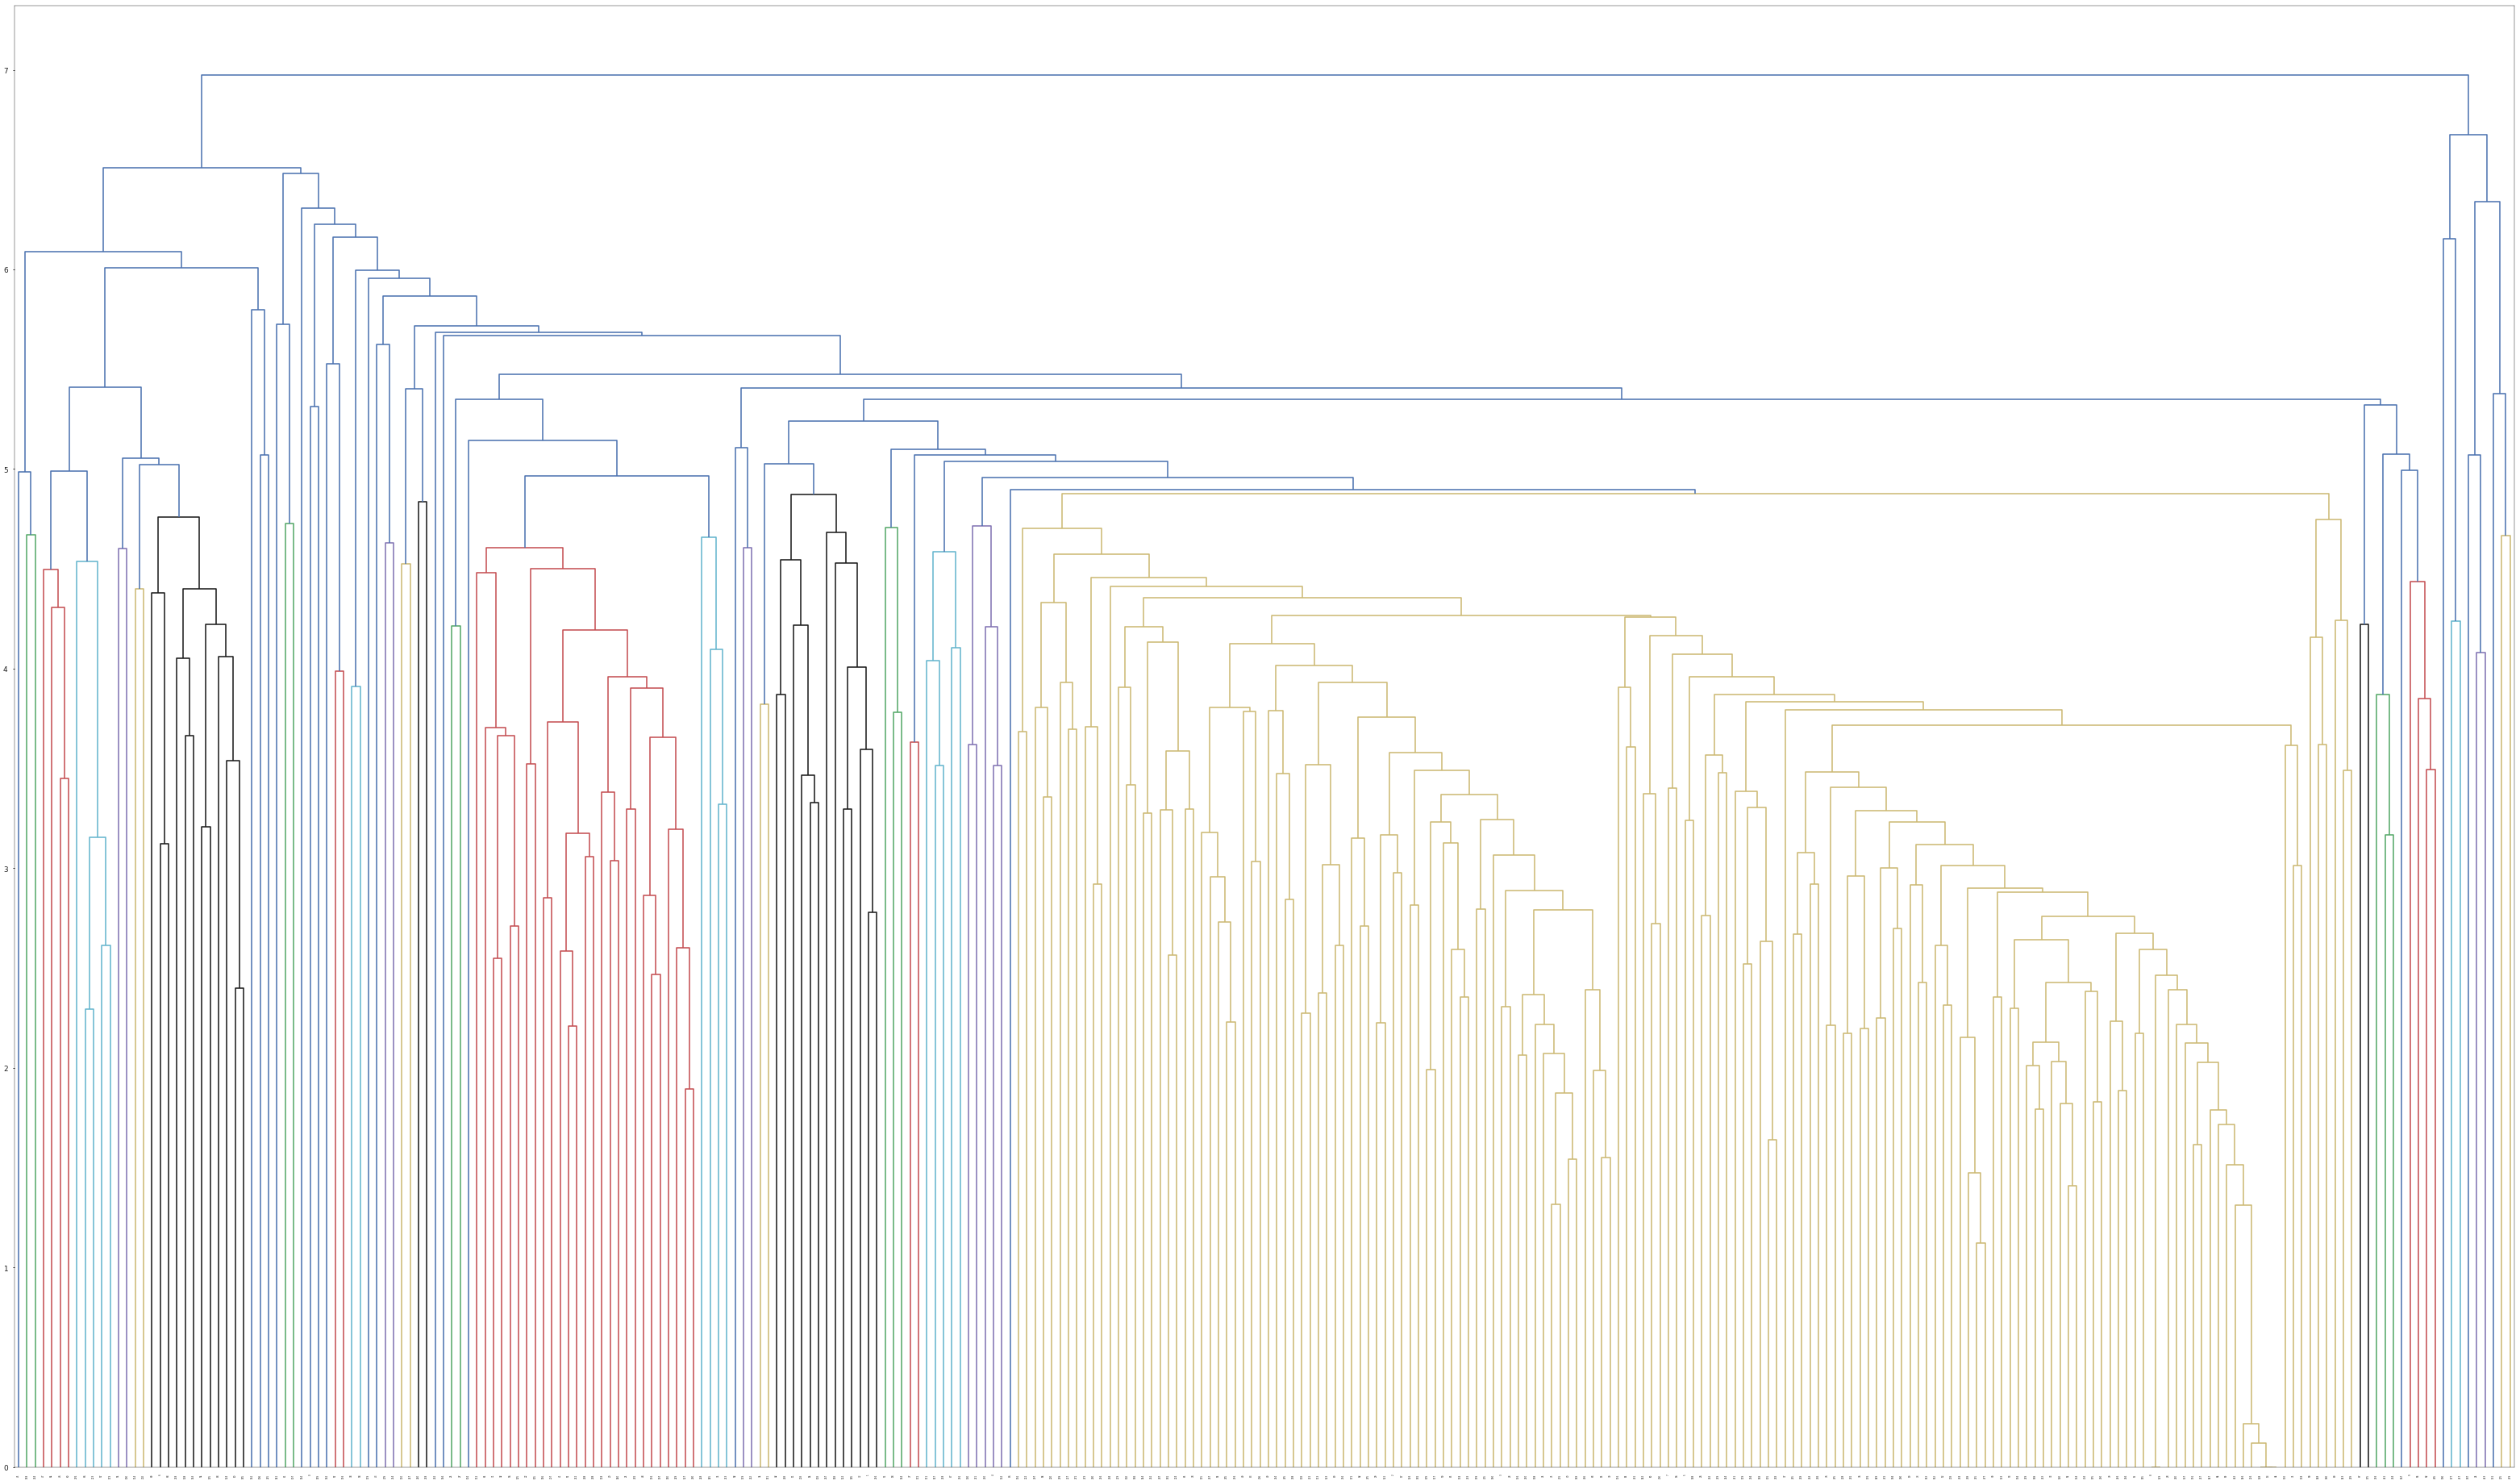

Milk + Honey JCC,12701 N Scottsdale Rd,Scottsdale,AZ
Four Peaks Brewing,1340 E 8th St, Ste 104,Tempe,AZ
Sorso Wine Room,15323 N Scottsdale Rd, Ste 150,Scottsdale,AZ
Phoenix City Grille,5816 N 16th St,Phoenix,AZ
B&R Wine - Food,7366 E Shea Blvd, Ste 112,Scottsdale,AZ
Panini Bread & Grill,3510 W Bell Rd,Glendale,AZ
Pasto di Forno,7116 E Mercer Ln, Ste 101,Scottsdale,AZ
Heroes Pub & Grub,5940 W Union Hills Dr,Glendale,AZ
Sugar Jam Bake Shop & Bistro,7950 E Redfield Rd,Scottsdale,AZ
Cafe 1010,1010 W Washington St,Phoenix,AZ
The Original Marketplace,7272 E Indian School Rd, Ste 105,Scottsdale,AZ
Local Play Yard Bar & Grill,3002 N Arizona Ave, Ste 1,Chandler,AZ
City Square Deli & Grill,22601 N 19th Ave, Ste 121,Phoenix,AZ
Starfire Grille,11500 N Hayden Rd,Scottsdale,AZ
CM2 Pizzeria & Bakeshop,11485 N 136th St,Scottsdale,AZ
Helio Basin Brewing,3935 E Thomas Rd,Phoenix,AZ
Local Jonny's,6033 E Cave Creek Rd,Cave Creek,AZ
Presidio Cocina Mexicana,519 W Thomas Rd,Phoenix,AZ
Shorty's Sandwich Shop

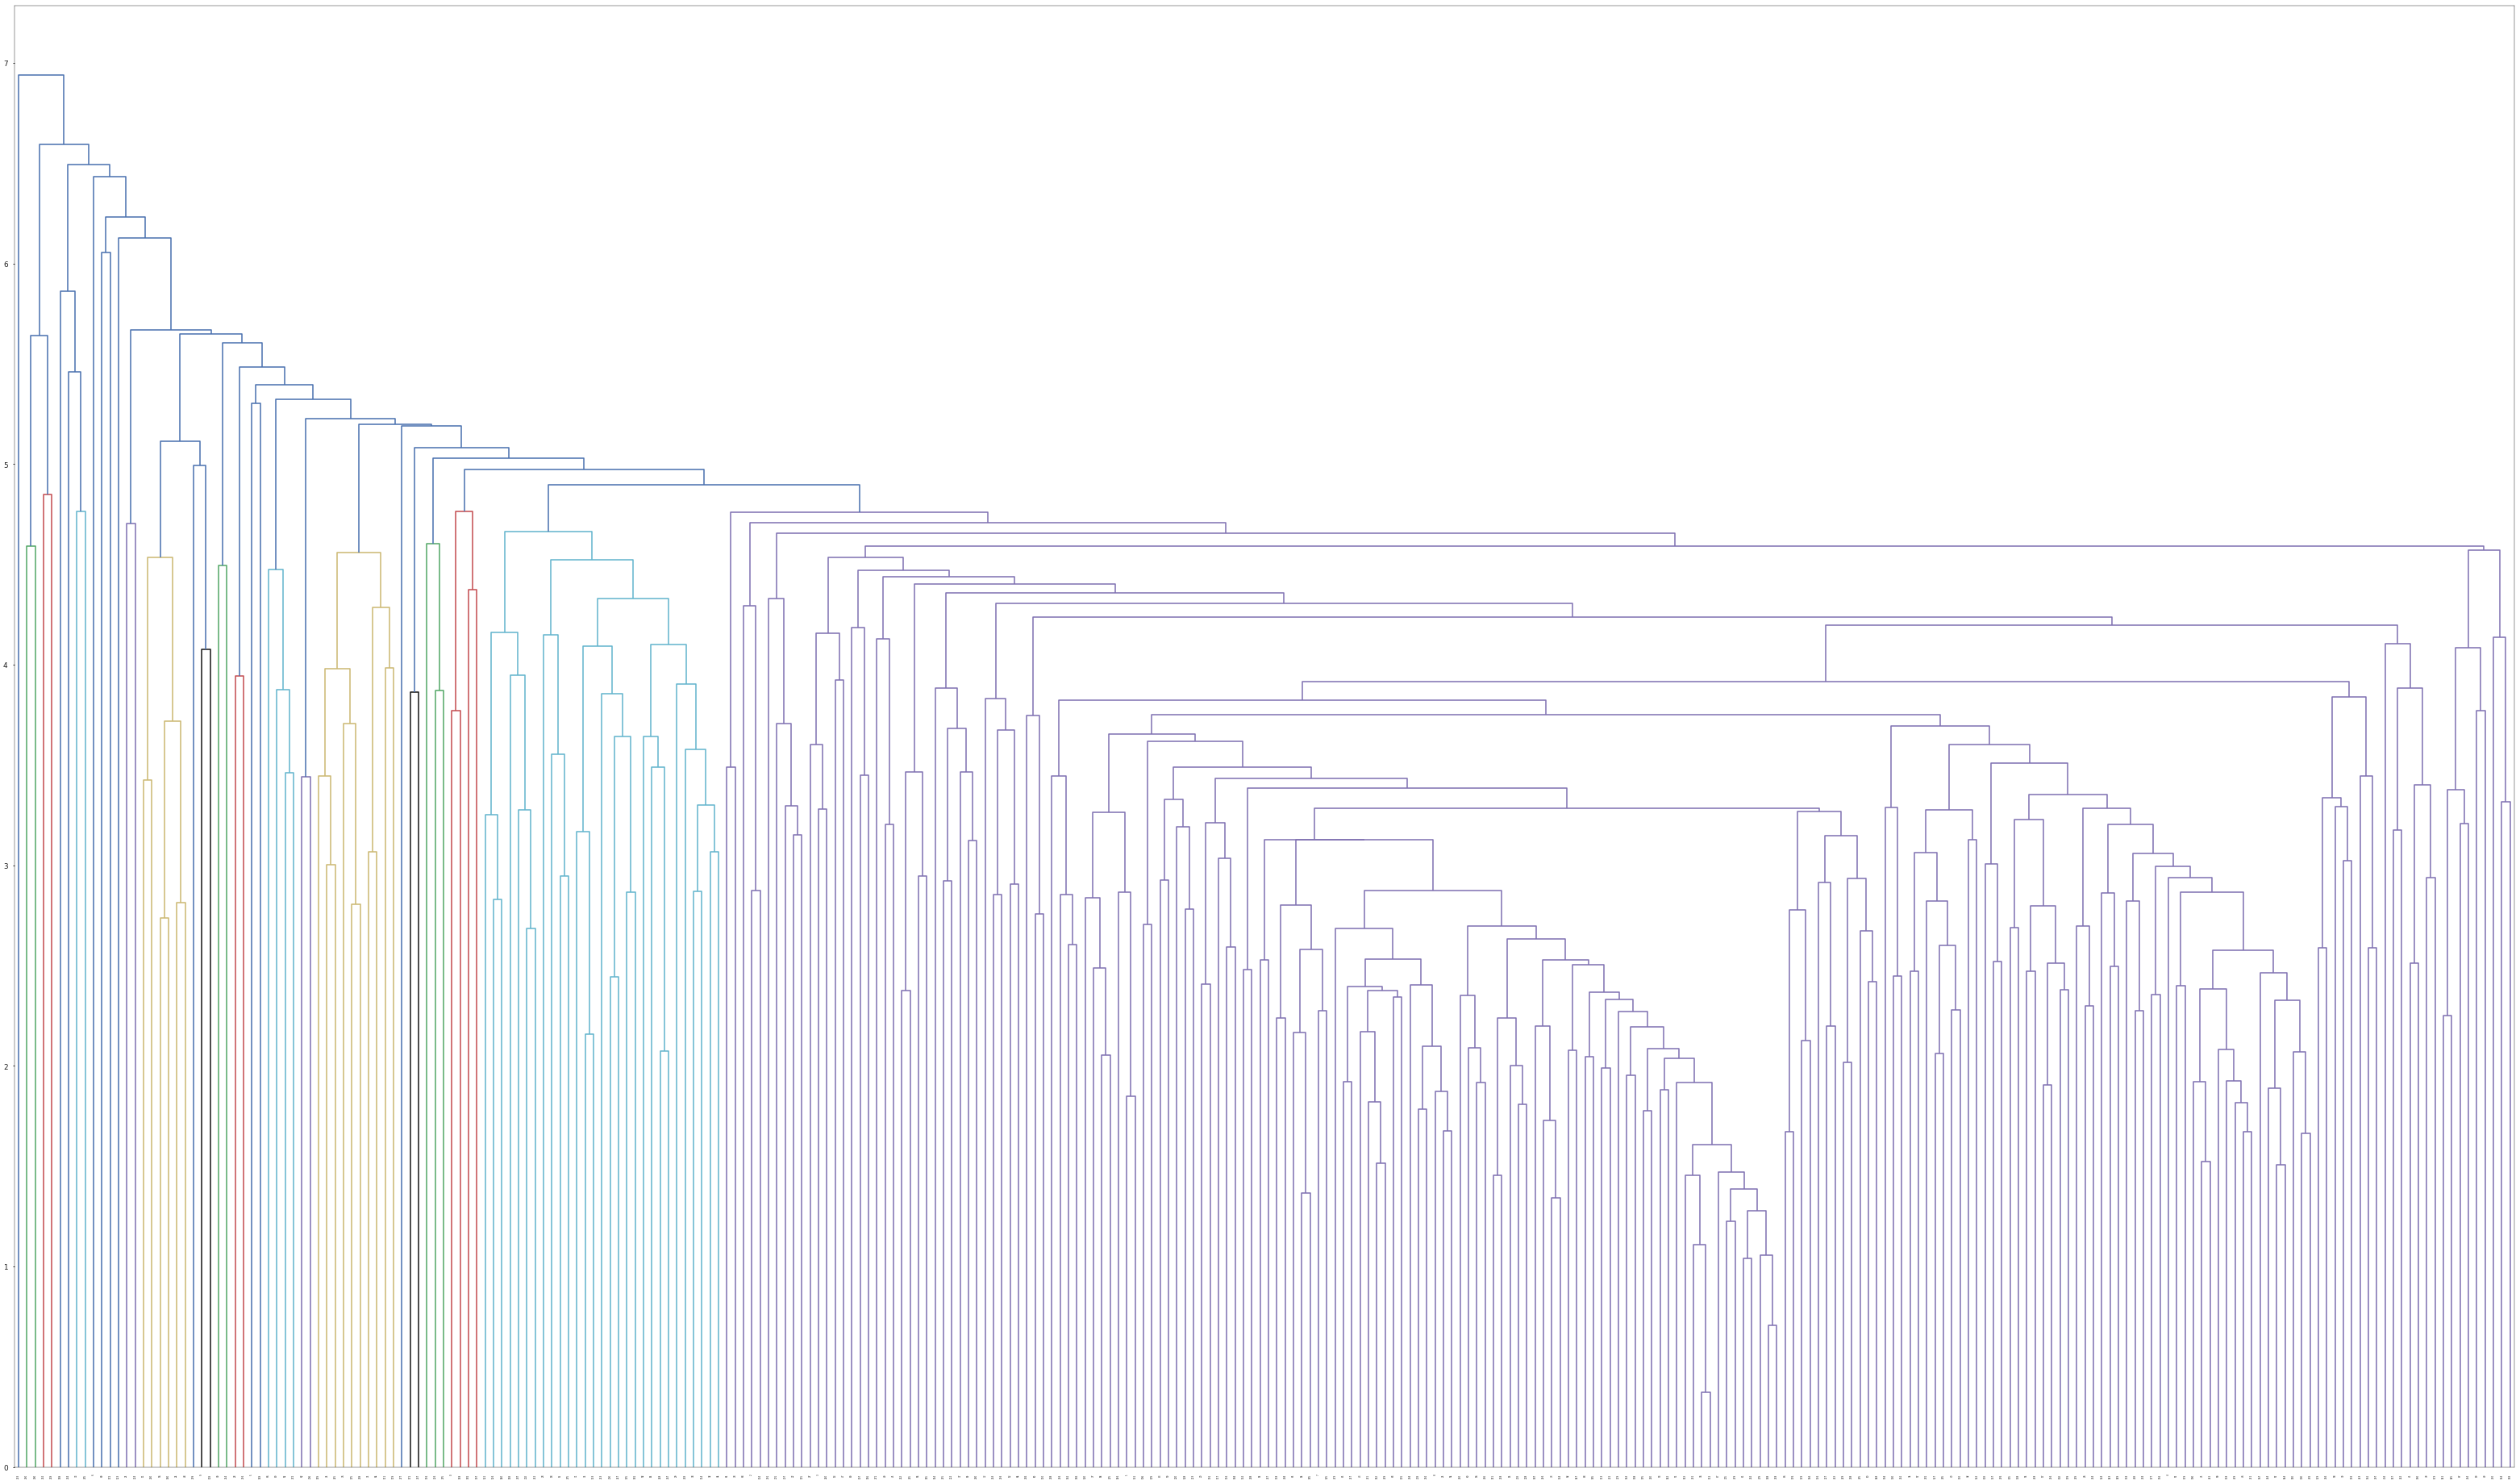

MoTo Coffee and Snack Bar,1321 Dundas Street W,Toronto,ON
Green Republic Food,439 University Avenue, Unit 105,Toronto,ON
Tim Horton,910 Lakeshore Road E,Mississauga,ON
Limelite Cafe,8540 Keele Street,Vaughan,ON
Paint Cabin,723 Gerrard Street E,Toronto,ON
Tesla Cafe,690 Euclid Avenue,Toronto,ON
Haute Coffee,153 Dupont Street,Toronto,ON
Zona Caffe,9401 Jane Street, Suite 119,Vaughan,ON
Scout & Cash Caffe,146 Christie Street,Toronto,ON
Voodoo Child,388 College Street,Toronto,ON
Page One,106 Mutual Street,Toronto,ON
The Porch Light,982 Kingston Road,Toronto,ON
Ciao Europa Cafe,80 Western Battery Road,Toronto,ON
Tatlows Broiler Bar,380 Queensville Side Road W,River Drive Park,ON
Raca Cafe and Bar,1704 Queen Street W,Toronto,ON
Noble Coffee,1421 Bloor Street W,Toronto,ON
The Merseyside,2413 Dundas Street W,Toronto,ON
Wraps On The Go,Cumberland Terrace, 2 Bloor Street W,Toronto,ON
Nature's Corner,302 Canboro Rd,Ridgeville,ON
Hit Ratio:  0.846153846154
NDCG:  0.830966116281





Recommendation

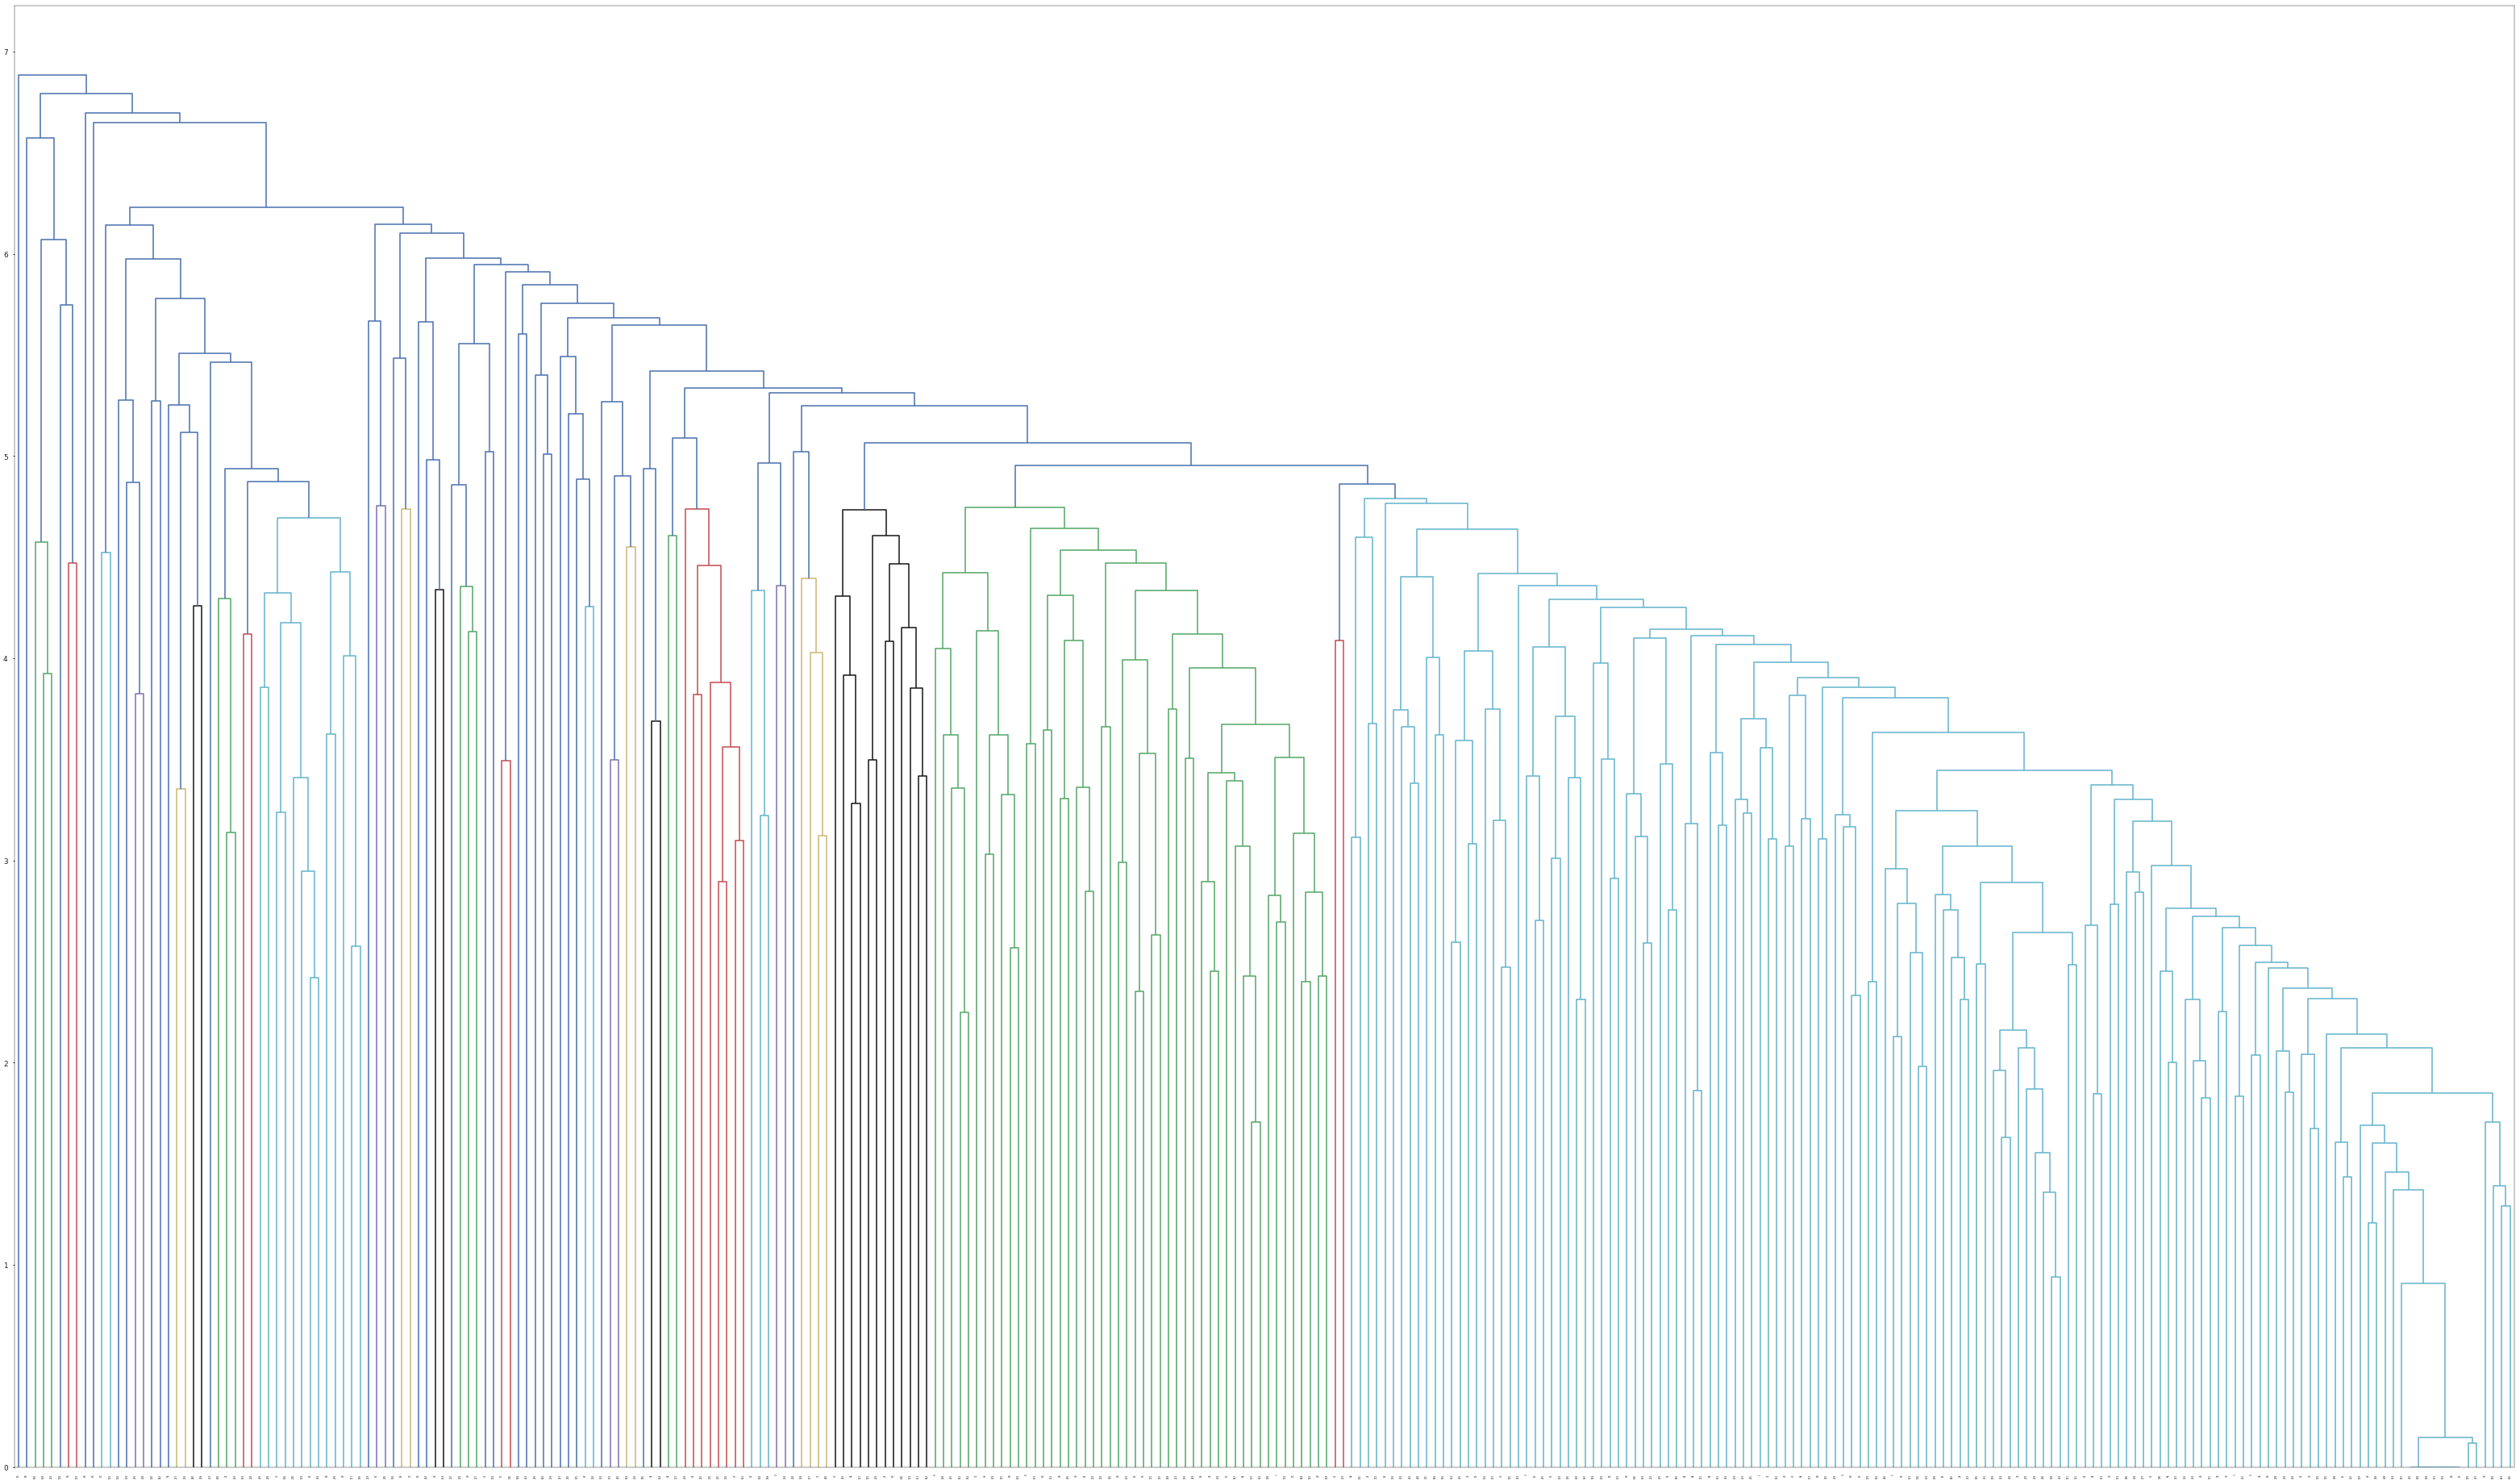

Served,1770 W Horizon Ridge, Ste 100,Henderson,NV
Jjanga Steak & Sushi,6125 S Fort Apache Rd, Ste 200,Las Vegas,NV
Gilligan's HideAway,2601 Atlantic St,Las Vegas,NV
Zest - Bistro & Bar,10670 Southern Highlands Pkwy, Ste 102,Las Vegas,NV
Pier 215,7060 S Durango Dr, Ste 101,Las Vegas,NV
Soho Sushi Burrito,6040 W Badura Ave, Ste 150,Las Vegas,NV
Modern Proteins,6475 W Charleston Blvd, Ste 110,Las Vegas,NV
Mojito Hut,3570 S Las Vegas Blvd,Las Vegas,NV
VIP Sushi and Karaoke,953 E Sahara Ave, Ste E-1A,Las Vegas,NV
Rachel's Kitchen,888 W Bonneville Ave,Las Vegas,NV
J Karaoke Bar,3899 Spring Mountain Rd,Las Vegas,NV
Toddy Shop,238 S Rainbow Blvd,Las Vegas,NV
Aroma Cuisine of the World/Oscar Catering,6370 W Flamingo Rd, Ste 30,Las Vegas,NV
Snack Bar,1220 E Harmon Ave, Ste A,Las Vegas,NV
Playa Papagayos,4760 W Sahara Ave, Ste 21,Las Vegas,NV
Costa Del Sol At Sunset Station,1301 W Sunset Road,Henderson,NV
King's  Sausage,,Las  Vegas,NV
Yard House,11011 W Charleston Blvd,Las Vegas,NV
Greens and Pr

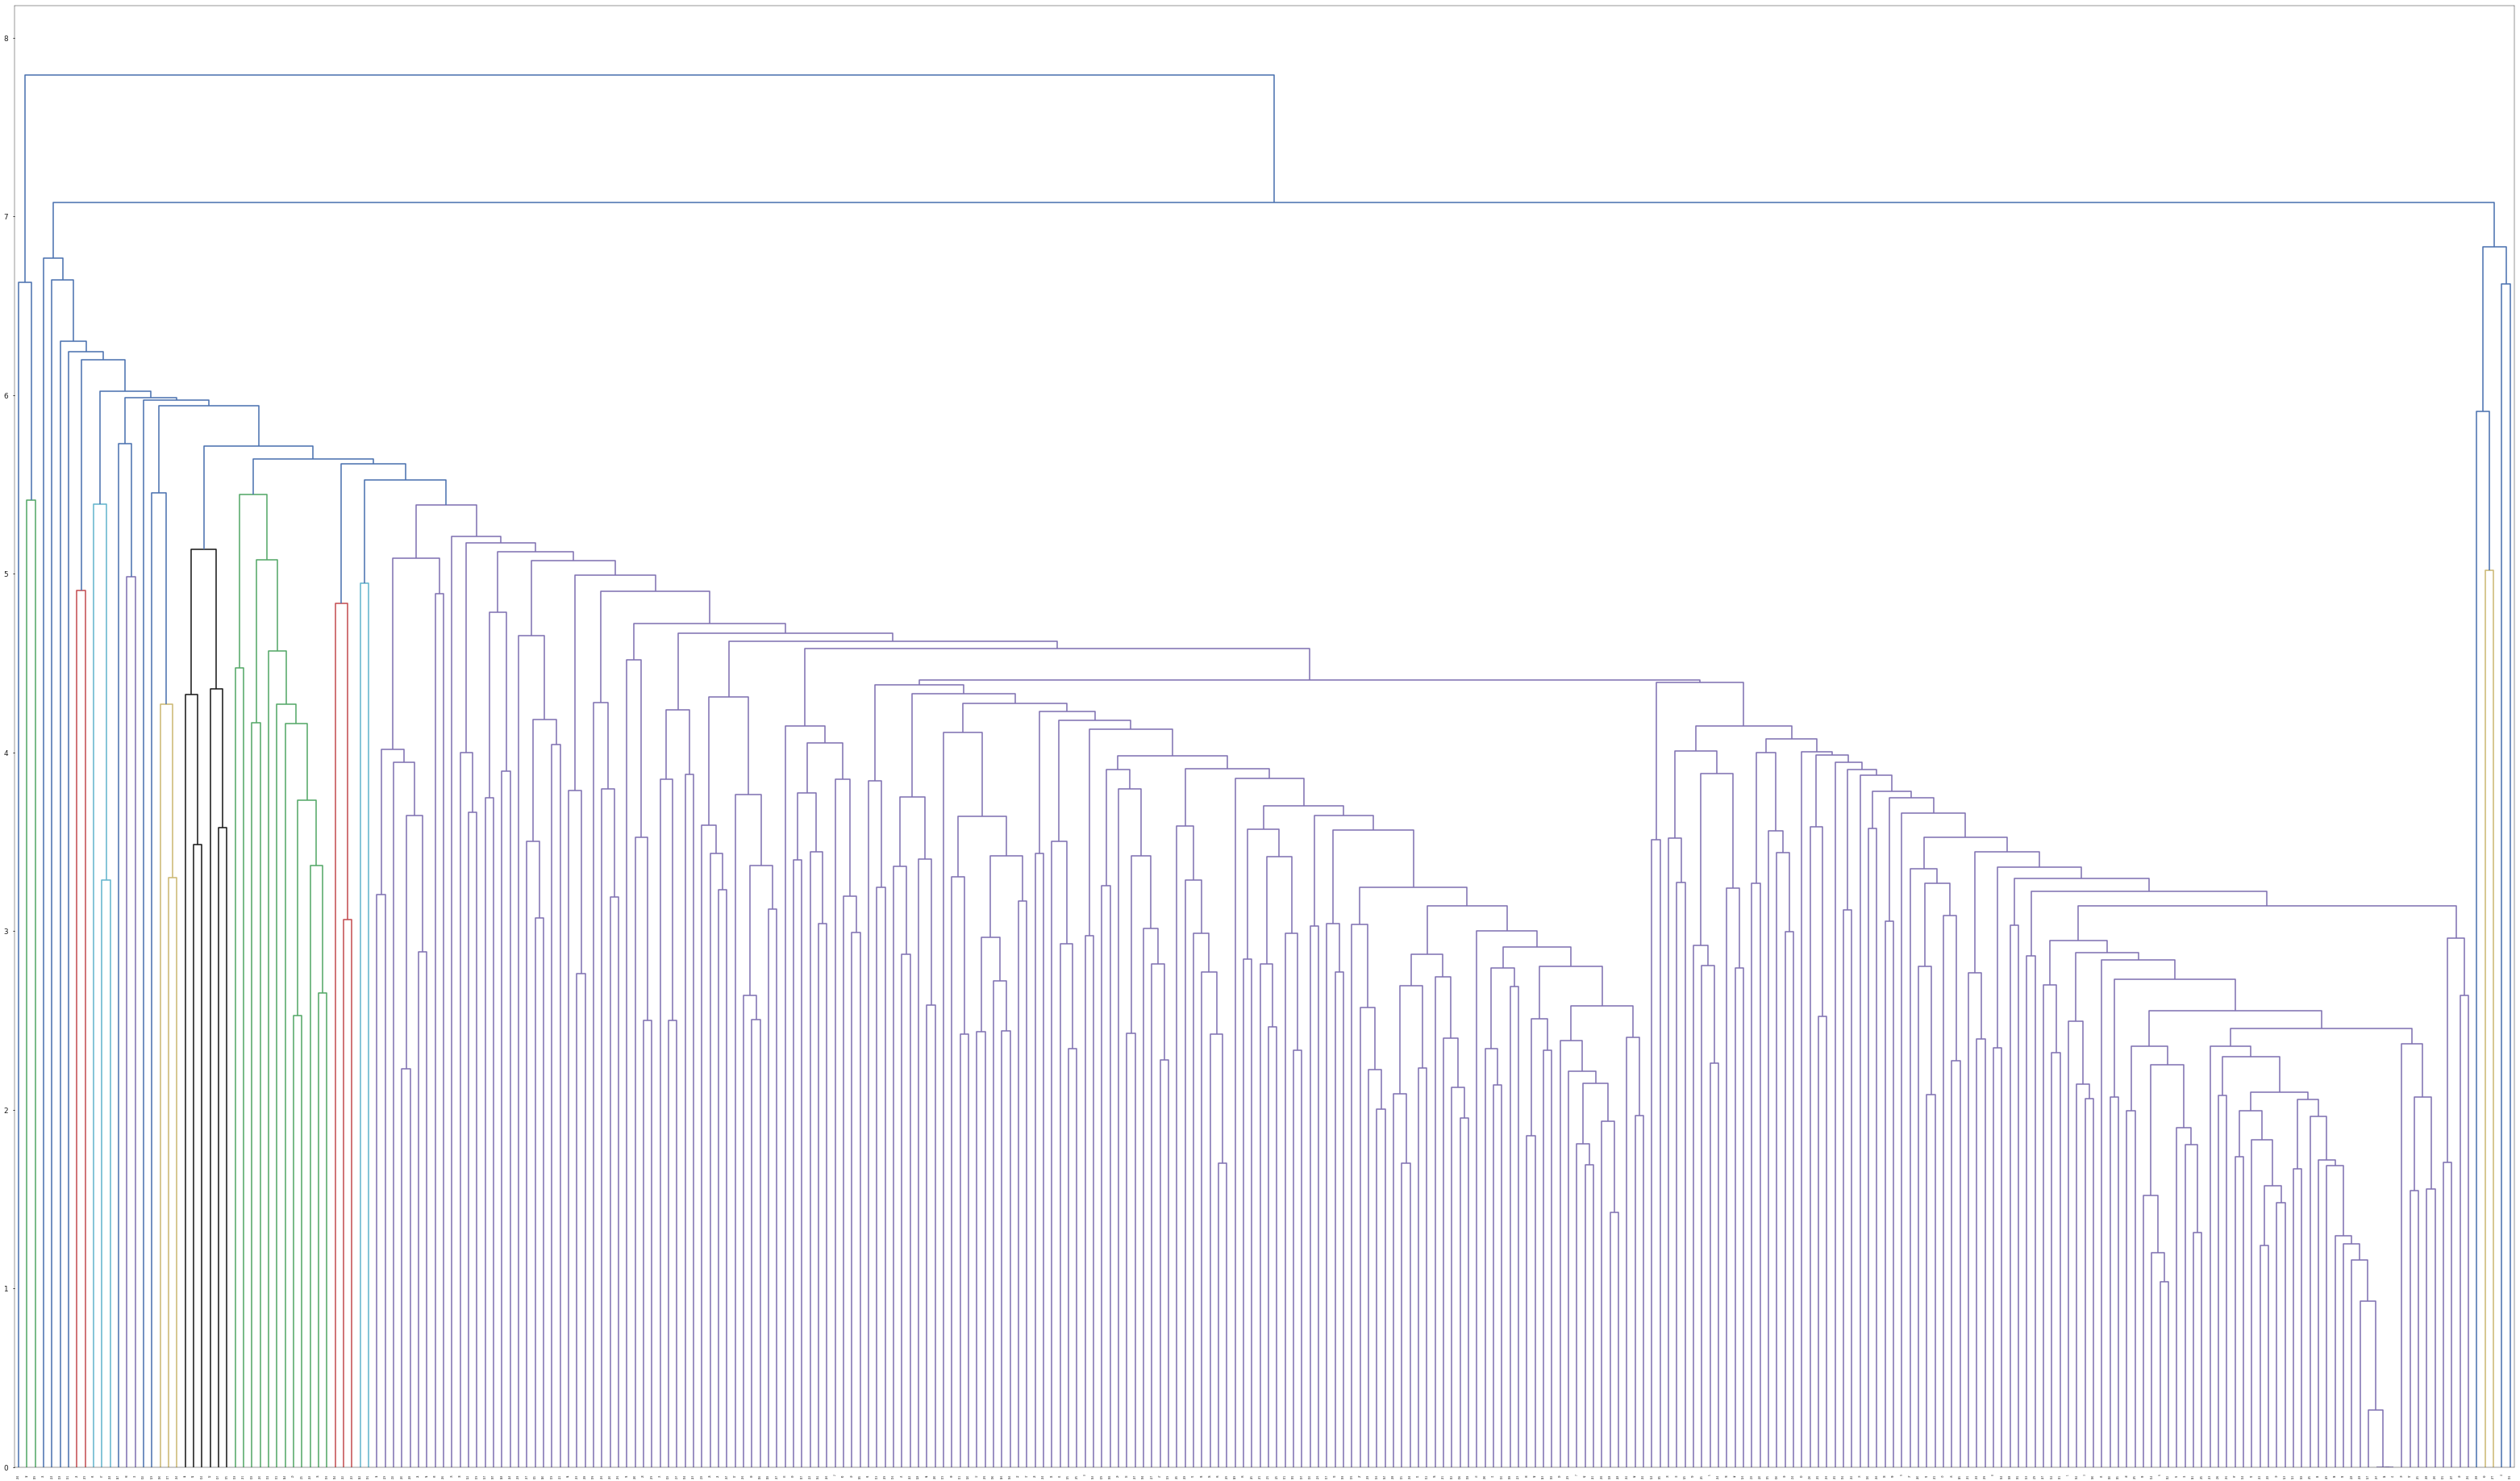

3 Brothers Pizza,7523 Pearl Rd,Middleburg Heights,OH
Beer & Belly Sports Grille,158 E Aurora,Northfield,OH
Herman's Pub & Grub,2126 Pearl Rd,Brunswick,OH
Rowley Inn,1104 Rowley Ave,Cleveland,OH
The Jailhouse Taverne,15478 Avon Belden Rd,Grafton,OH
Speedys Grub Shack,14001 Lakewood Heights Blvd,Cleveland,OH
Chick-fil-A,9611 Mentor Ave,Mentor,OH
Steak 'n Shake,6880 Ridge Rd,Parma,OH
Lake City Tavern,786 Front St,Berea,OH
Belladona'a,6200 Enterprise Pkwy,Solon,OH
Franklin Hotel Bar,176 E Main St,Kent,OH
Mr. Hero,27315 Detroit Rd,Westlake,OH
The Field,4112 State Rt 43,Kent,OH
Just One More Tavern,9378 Chillicothe Rd,Kirtland,OH
Marjees Bar & Grill,3604 Superior Ave,Cleveland,OH
Nosh Eatery & Creative Catering,5929 Darrow Rd,Hudson,OH
Grindstone Tap House,826 Front St,Berea,OH
Fat Head's Brewery & Tap House,18741 Sheldon Rd,Middleburg Heights,OH
The Side Quest,17900 Detroit Ave,Lakewood,OH
Hit Ratio:  0.904761904762
NDCG:  0.886339215669





Recommendation info summary for :  PA
number of 

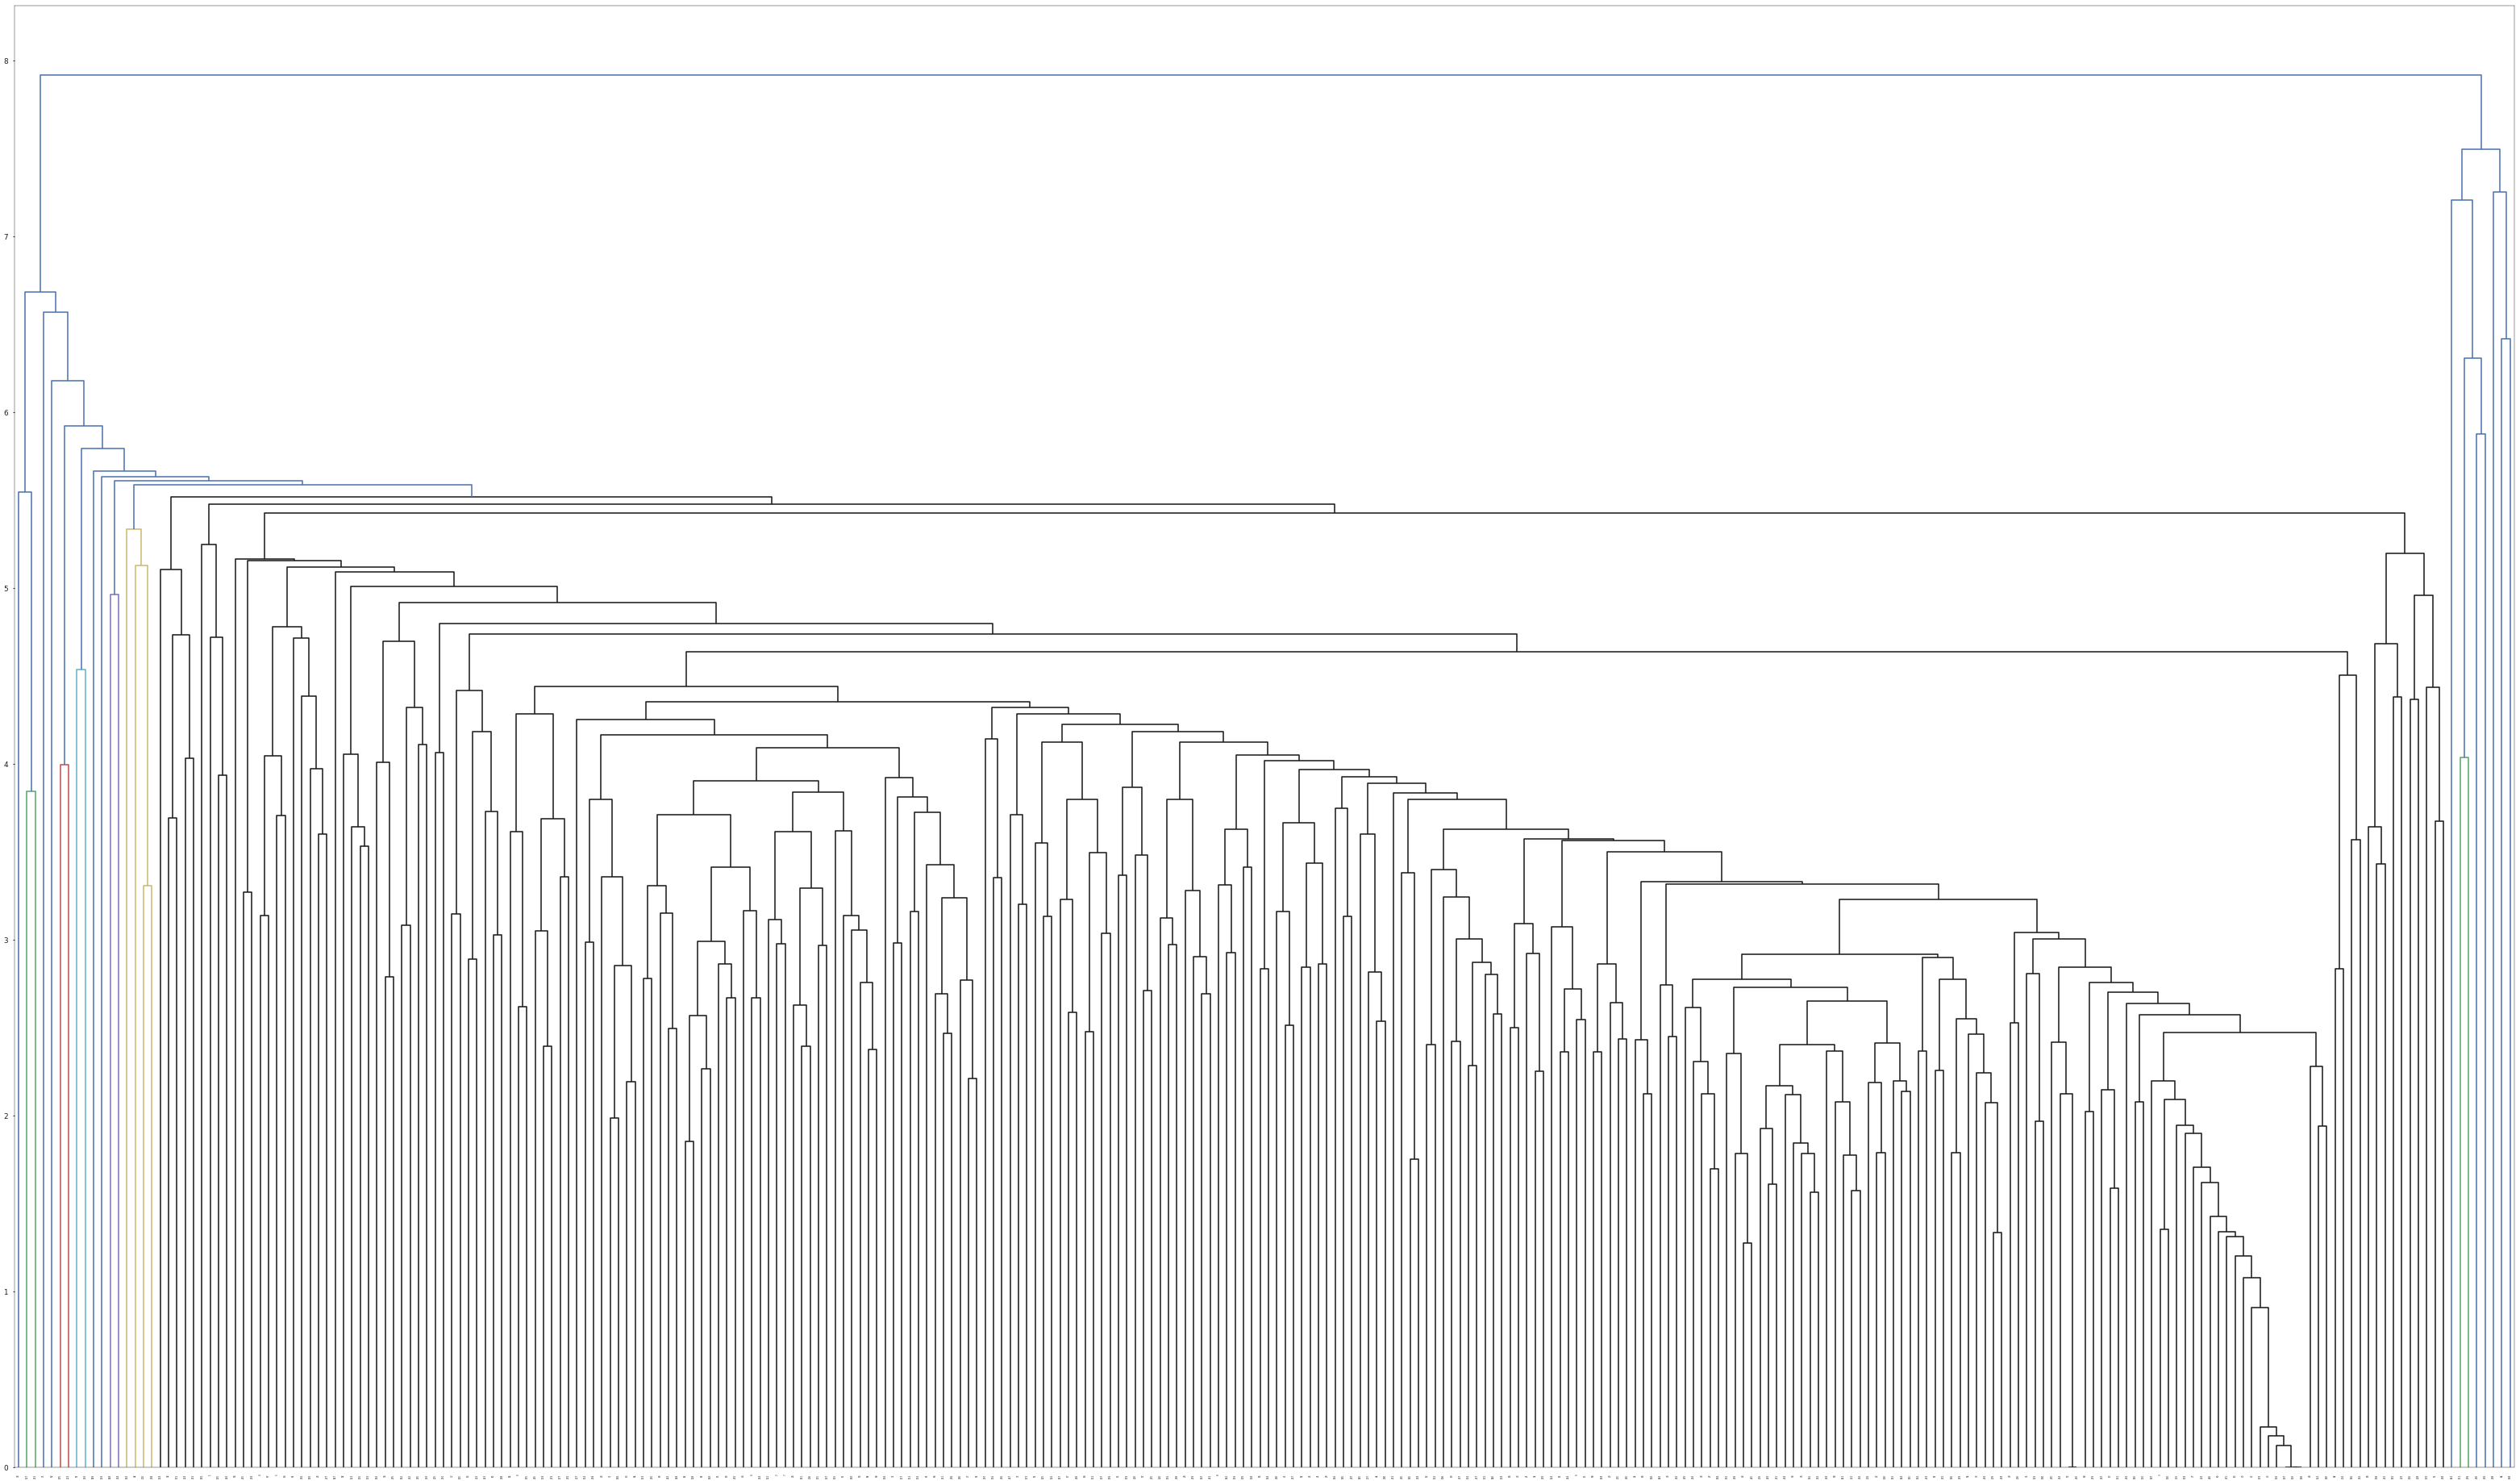

Cocothe,545 Beaver St,Sewickley,PA
Bishop's Corner Café,4701 Campbells Run Rd,Pittsburgh,PA
Smallman Galley,54 21st St,Pittsburgh,PA
Mixtape,4907 Penn Ave,Pittsburgh,PA
Duss Ave Cafe,1811 Duss Ave,Ambridge,PA
Perspolis Hookah Lounge,304 N Craig St,Pittsburgh,PA
Elwood's Pub,163 Little Deer Creek Rd,Rural Ridge,PA
Three Little Birds Cafe & Juice Bar,3447 Harts Run Rd,Glenshaw,PA
Tupelo Honey Teas,211 Grant Ave,Millvale,PA
S&D Cafe,1425 Forbes Ave,Pittsburgh,PA
Black & Cold Creamery,1854 Homeville Rd,West Mifflin,PA
Arancini House,615 Washington Rd,Pittsburgh,PA
Burgh Bites,1709 E Railroad St,Heidelberg,PA
Aunt Cheryl's Cafe,416 Library St,Braddock,PA
Joey D's in the Park, RIDC,180 Gamma Dr,Pittsburgh,PA
Leaf and Plate,5884 Ellsworth Ave, 1st Fl,Pittsburgh,PA
Altius,1230 Grandview Ave,Pittsburgh,PA
Proper Brick Oven & Tap Room,139 7th St,Pittsburgh,PA
Colony Café,1125 Penn Ave,Pittsburgh,PA
Hit Ratio:  0.92
NDCG:  0.904483361027





Recommendation info summary for :  NC
number of valid 

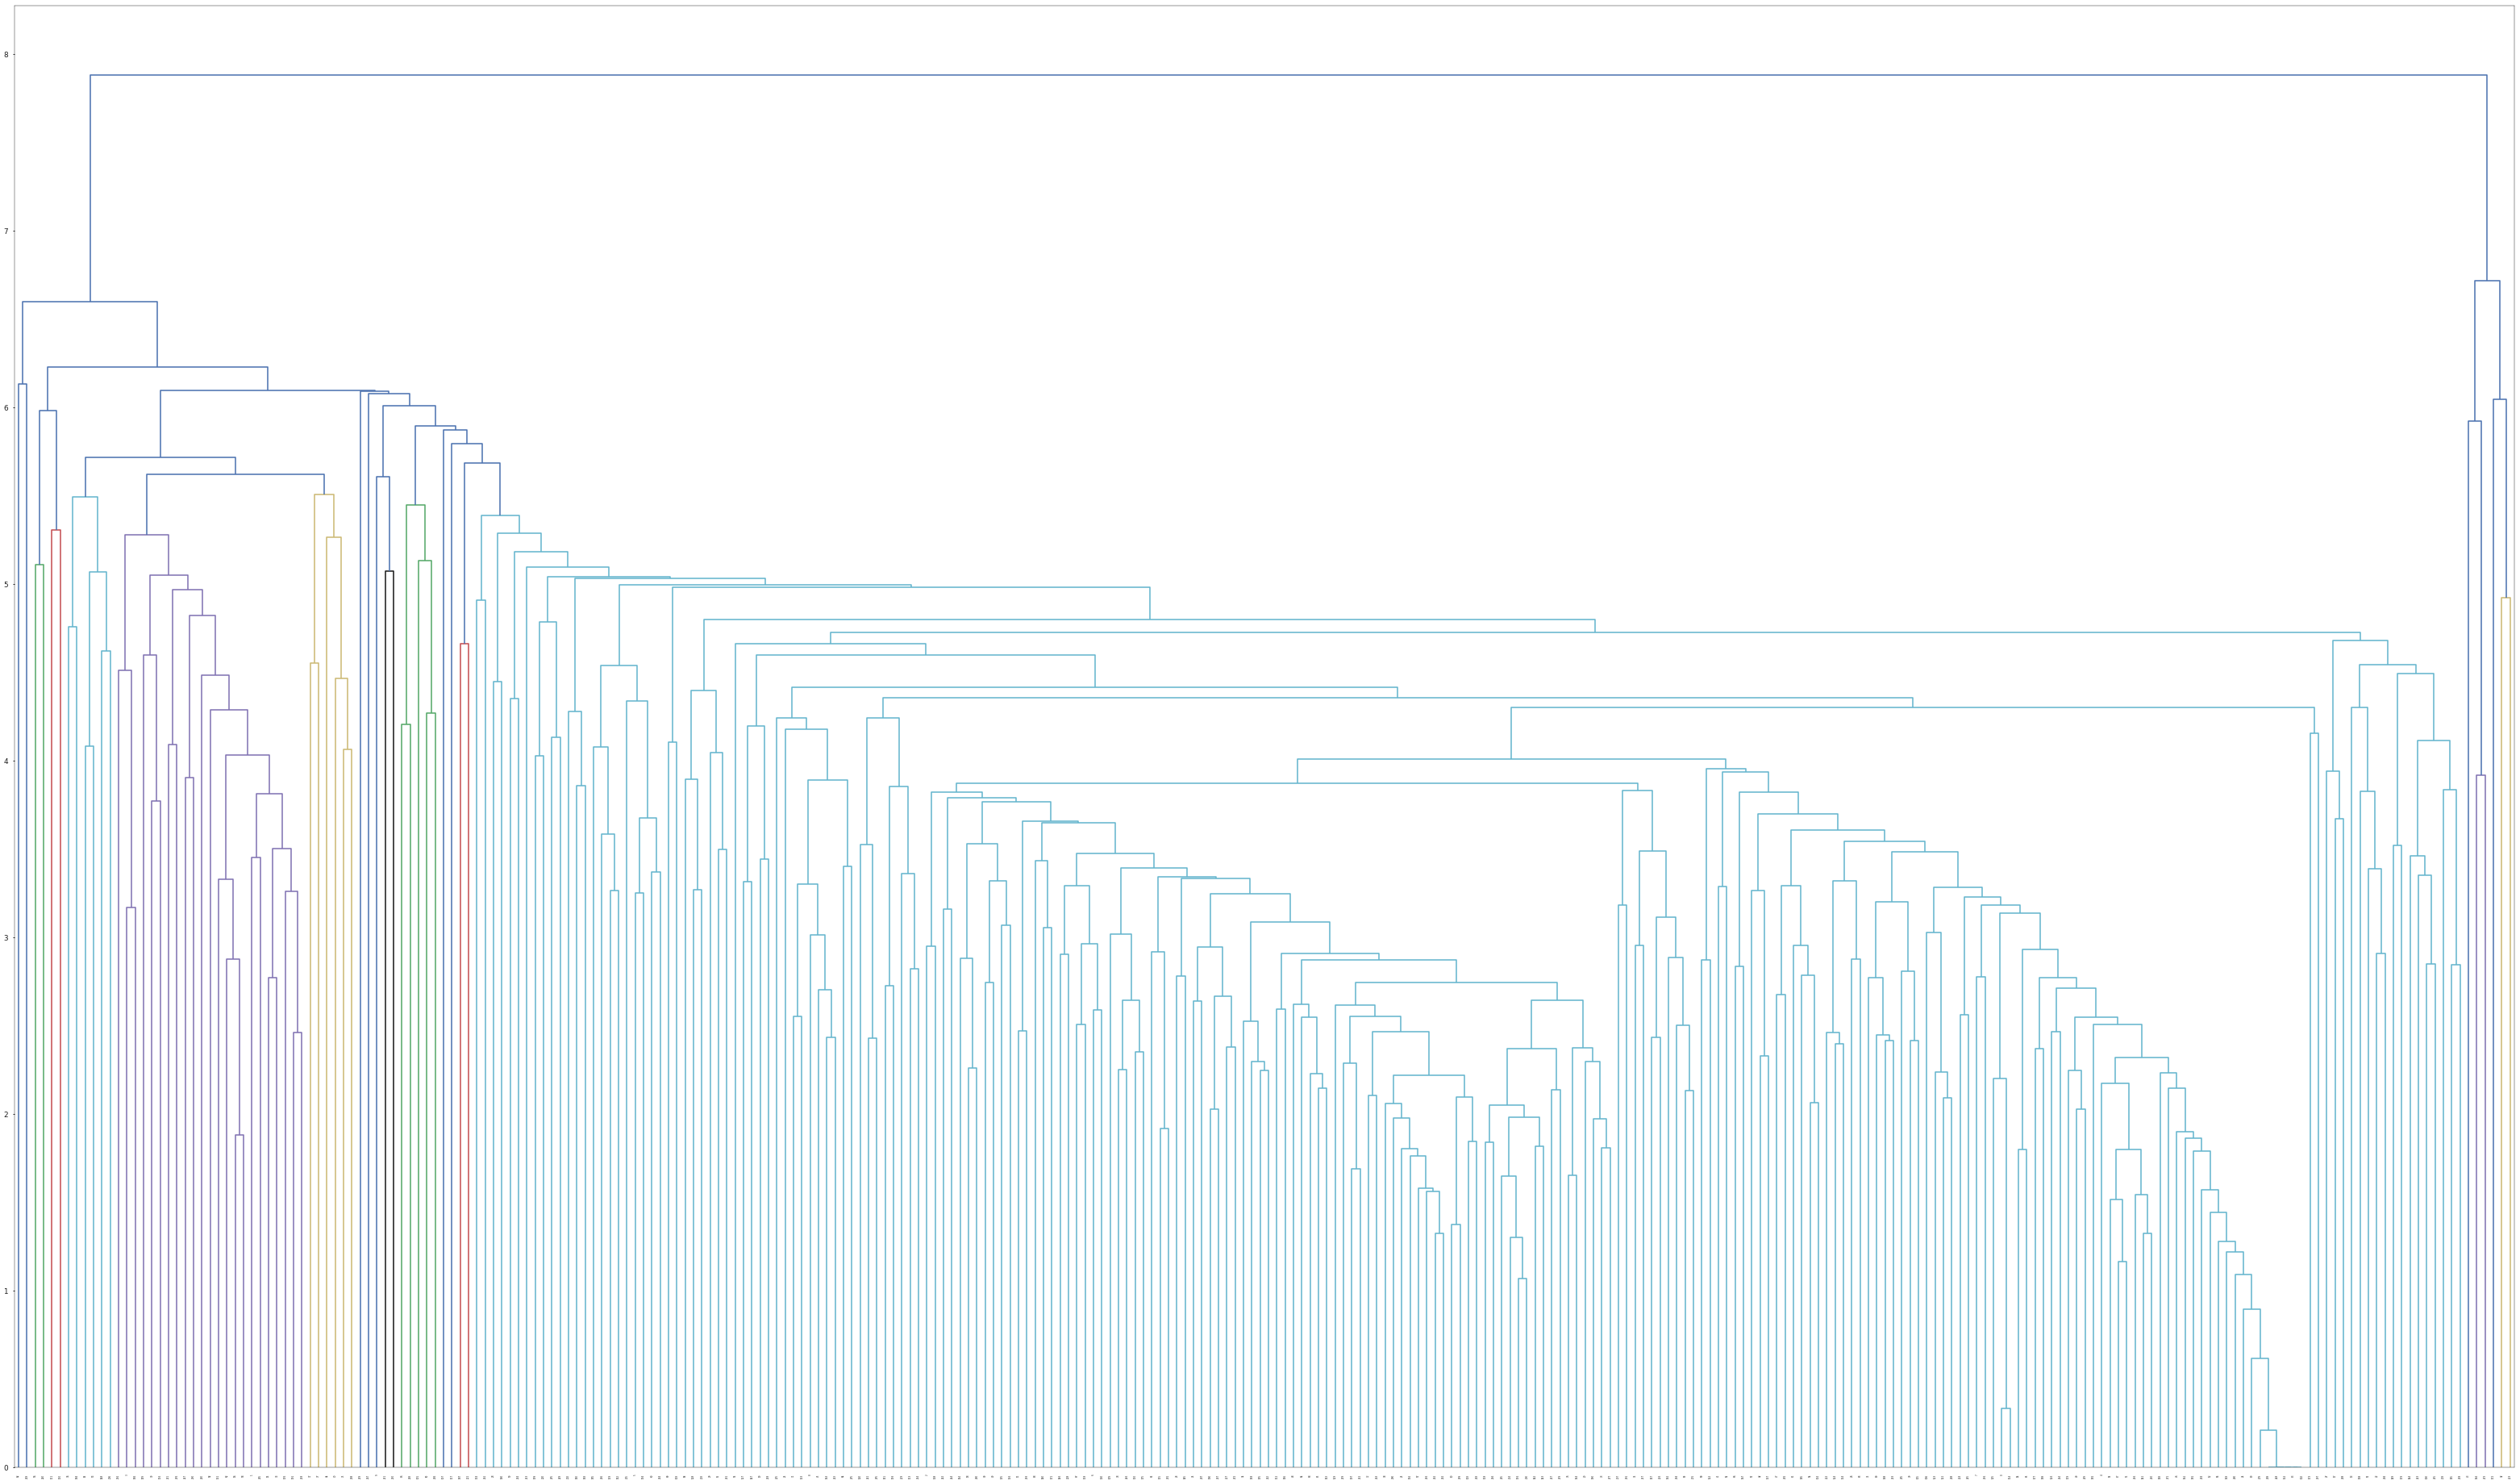

Artful Gourmet Carryout Catering,131 E John St,Matthews,NC
The Common Market Oakwold,4420 Monroe Rd,Charlotte,NC
49 Yardline,4539 N Carolina 49,Harrisburg,NC
Pineville Tavern,314 N Polk St,Pineville,NC
Jive Turkey Legs Food Truck,7005 Wilkinson Blvd, Ste H,Belmont,NC
The Cookin Coop,,Charlotte,NC
The Tasty Bowl Subs N Such,2900 Westinghouse Blvd, Ste 116,Charlotte,NC
Chicken King,3222 Rozzelles Ferry Rd,Charlotte,NC
Circles Grill and Market,8129 Ardrey Kell Rd,Charlotte,NC
Great Harvest Bread,1824 E Arbors Dr, Ste 390,Charlotte,NC
Saveeda's American Bistro,5922 Weddington Rd, Ste A13,Wesley Chapel,NC
Crispys Bar And Grill,3399 Cloverleaf Pkwy,Kannapolis,NC
Rhino Market & Deli,1500 W Morehead St, Ste E,Charlotte,NC
Ferrucci's Old Tyme Italian Market,20910 Torrence Chapel Rd,Cornelius,NC
The Turnhouse Grille,1600 E Woodlawn Rd, Ste 100,Charlotte,NC
Murphy's Kitchen & Tap,445 W Trade St,Charlotte,NC
Bedder Bedder & Moore Montford-Abbey,1730 Abbey Pl, Ste 4,Charlotte,NC
300 East,300 East B

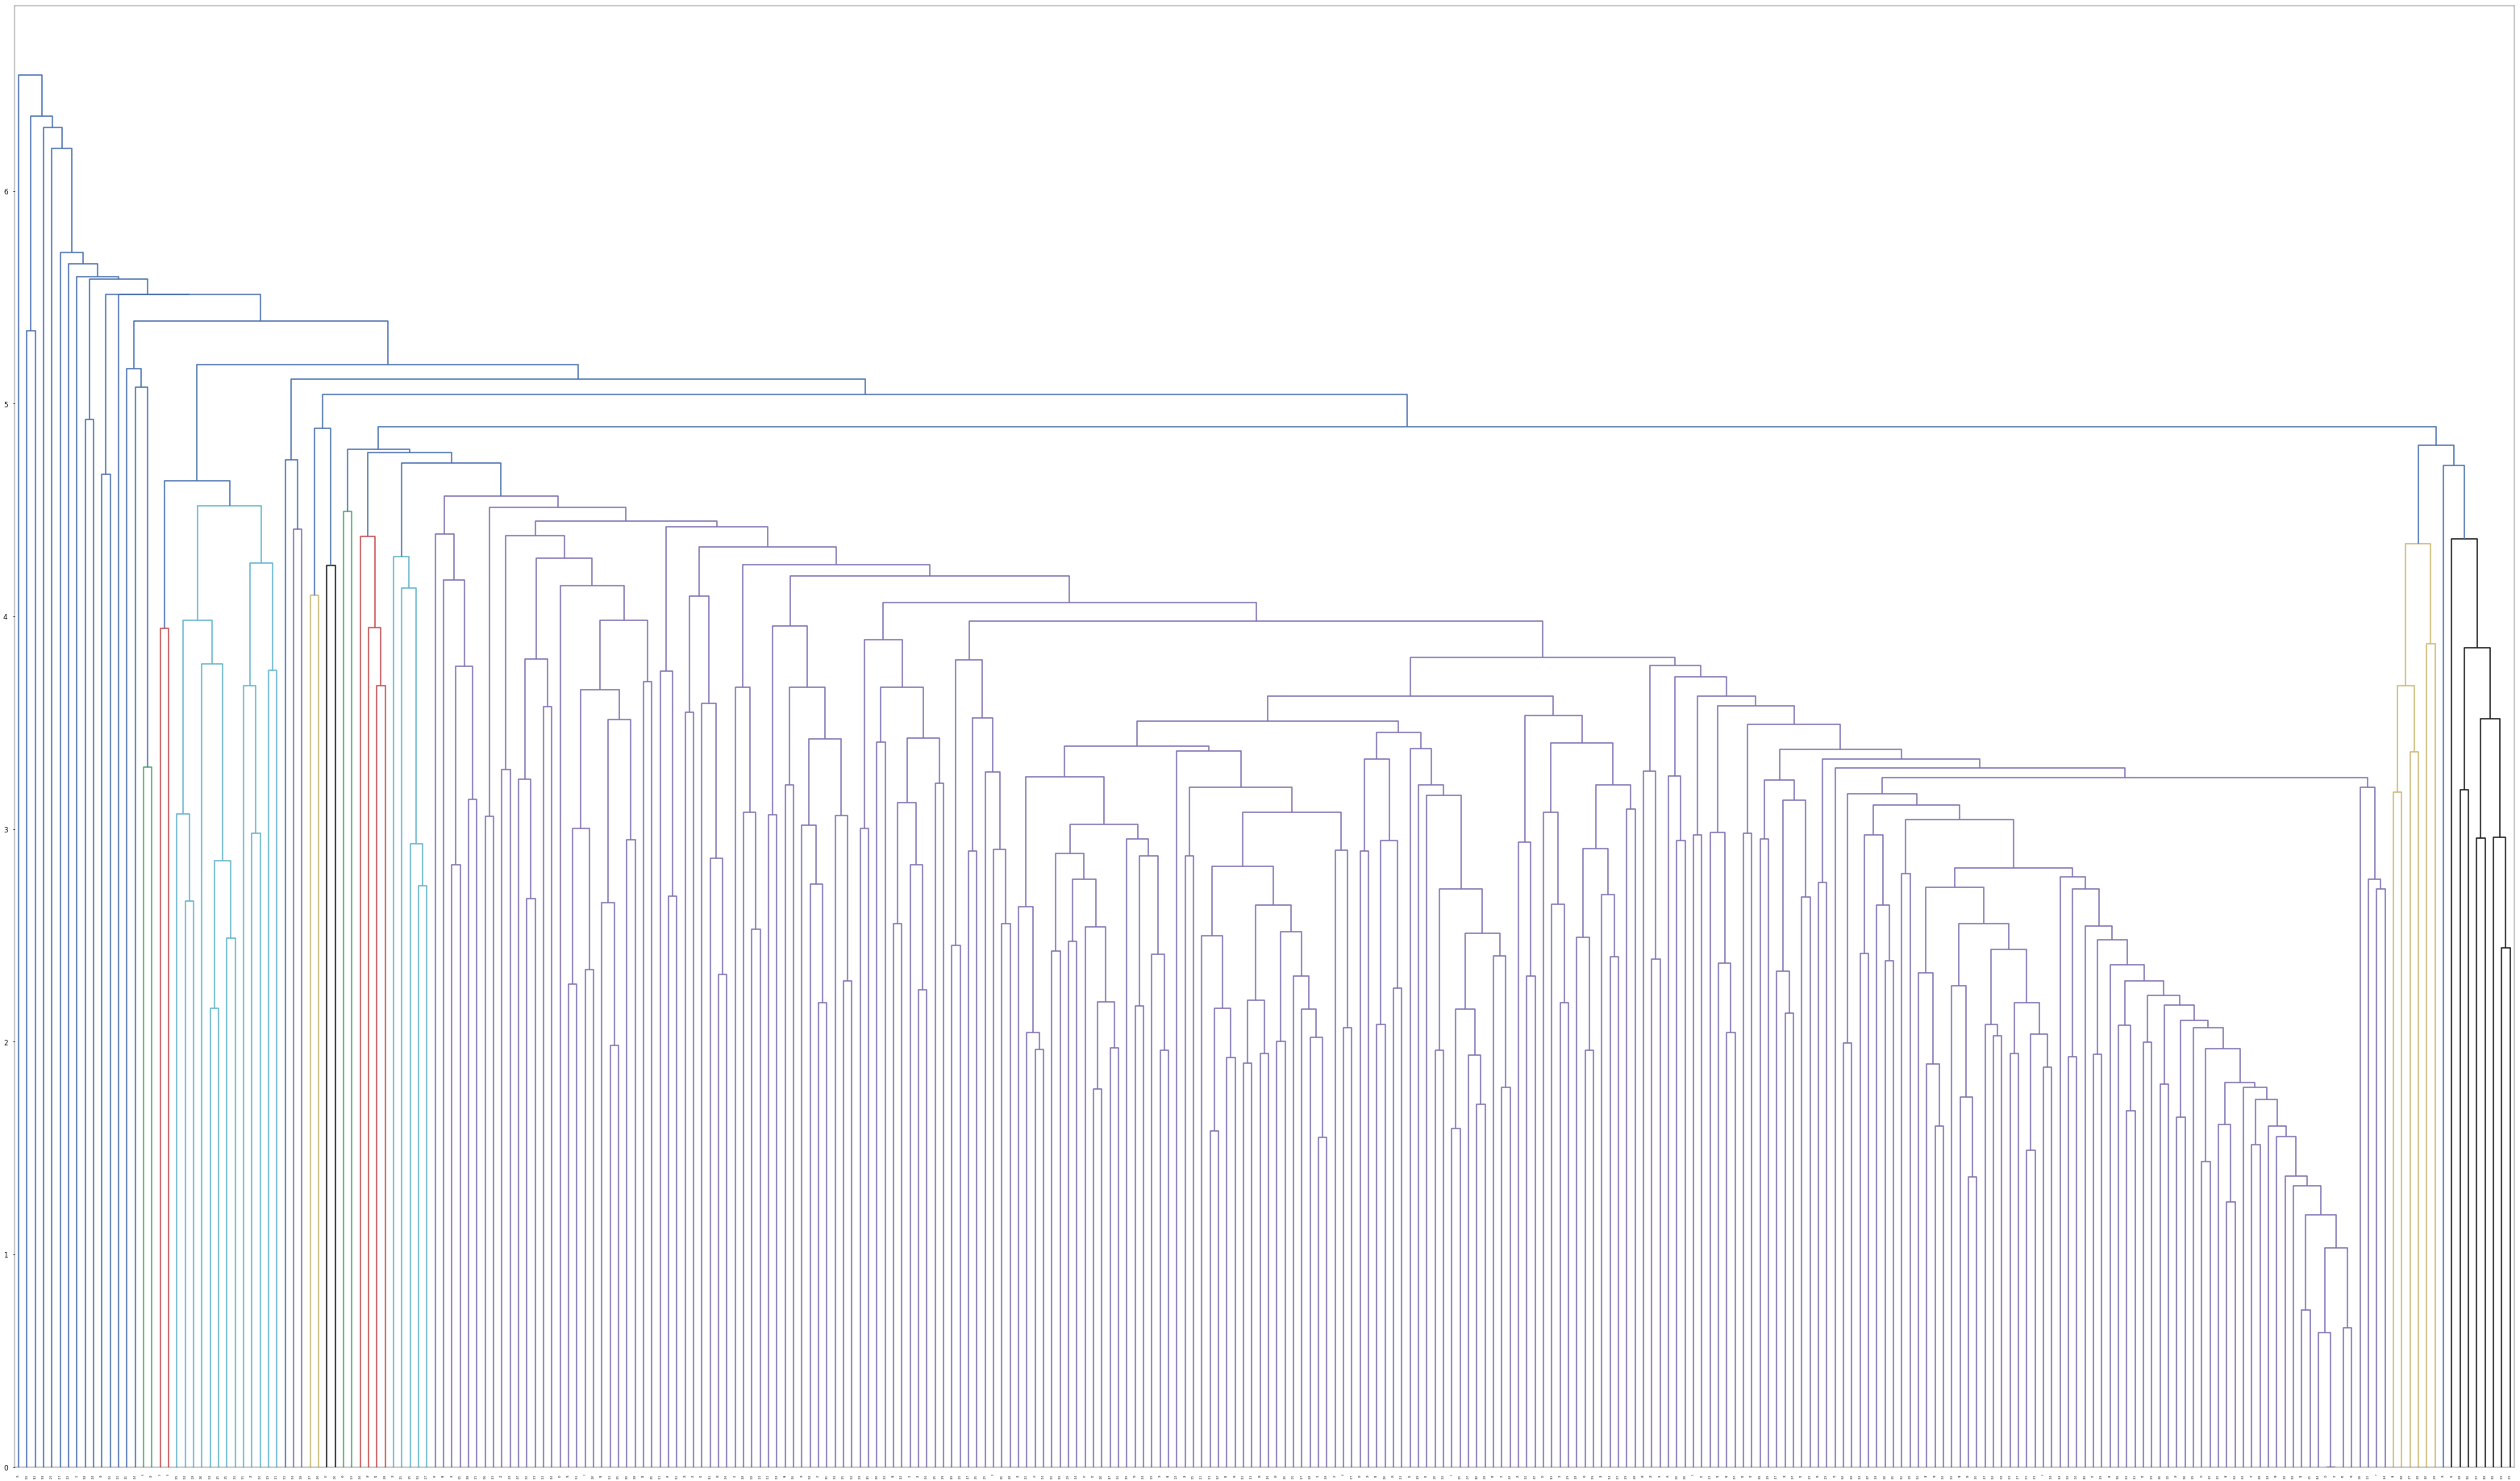

Deux - Cave à Manger,2 Rue Turgeon,Sainte-Therese,QC
Le Petit Brûloir,8485 Boulevard Saint-Laurent,Montréal,QC
Café de' Mercanti,350 Rue Notre-Dame Est,Montréal,QC
Novanta Café,90 Avenue Laurier O,Montréal,QC
Green,443 Avenue Viger O,Montréal,QC
Saint-Laurent Café,578 Rue Saint-Charles,Boucherville,QC
Brulerie Mondor,1395 Rue Des Cascade,Saint-Hyacinthe,QC
Belém Café & Yoga - L'Espace Café,4409 Boulevard Saint-Laurent,Montréal,QC
Bouffe Dave Plant Food,1206 Boulevard de Maisonneuve E,Montréal,QC
Café Aléatoire,1964 rue Notre-Dame ouest,Montréal,QC
Chez Lavigne,4280 Rue Notre-Dame O,Montréal,QC
Giovannina Pizzeria,151 Notre-Dame Sud,Sainte-Marie,QC
Un Autre Restaurant,200 Rue Saint-Viateur Ouest,Montréal,QC
Restaurant Épik,171 Rue Saint-Paul O,Montréal,QC
La Rouladerie,1205 Avenue Bernard,Montréal,QC
Café Tuyo,370 Rue Marie-Anne,Montréal,QC
Le Majestique,4105 Boulevard Saint-Laurent,Montréal,QC
Farine,102 Saint-Viateur Ouest,Montréal,QC
Auberge du Dragon Rouge,8870 Rue Lajeunesse,Montré

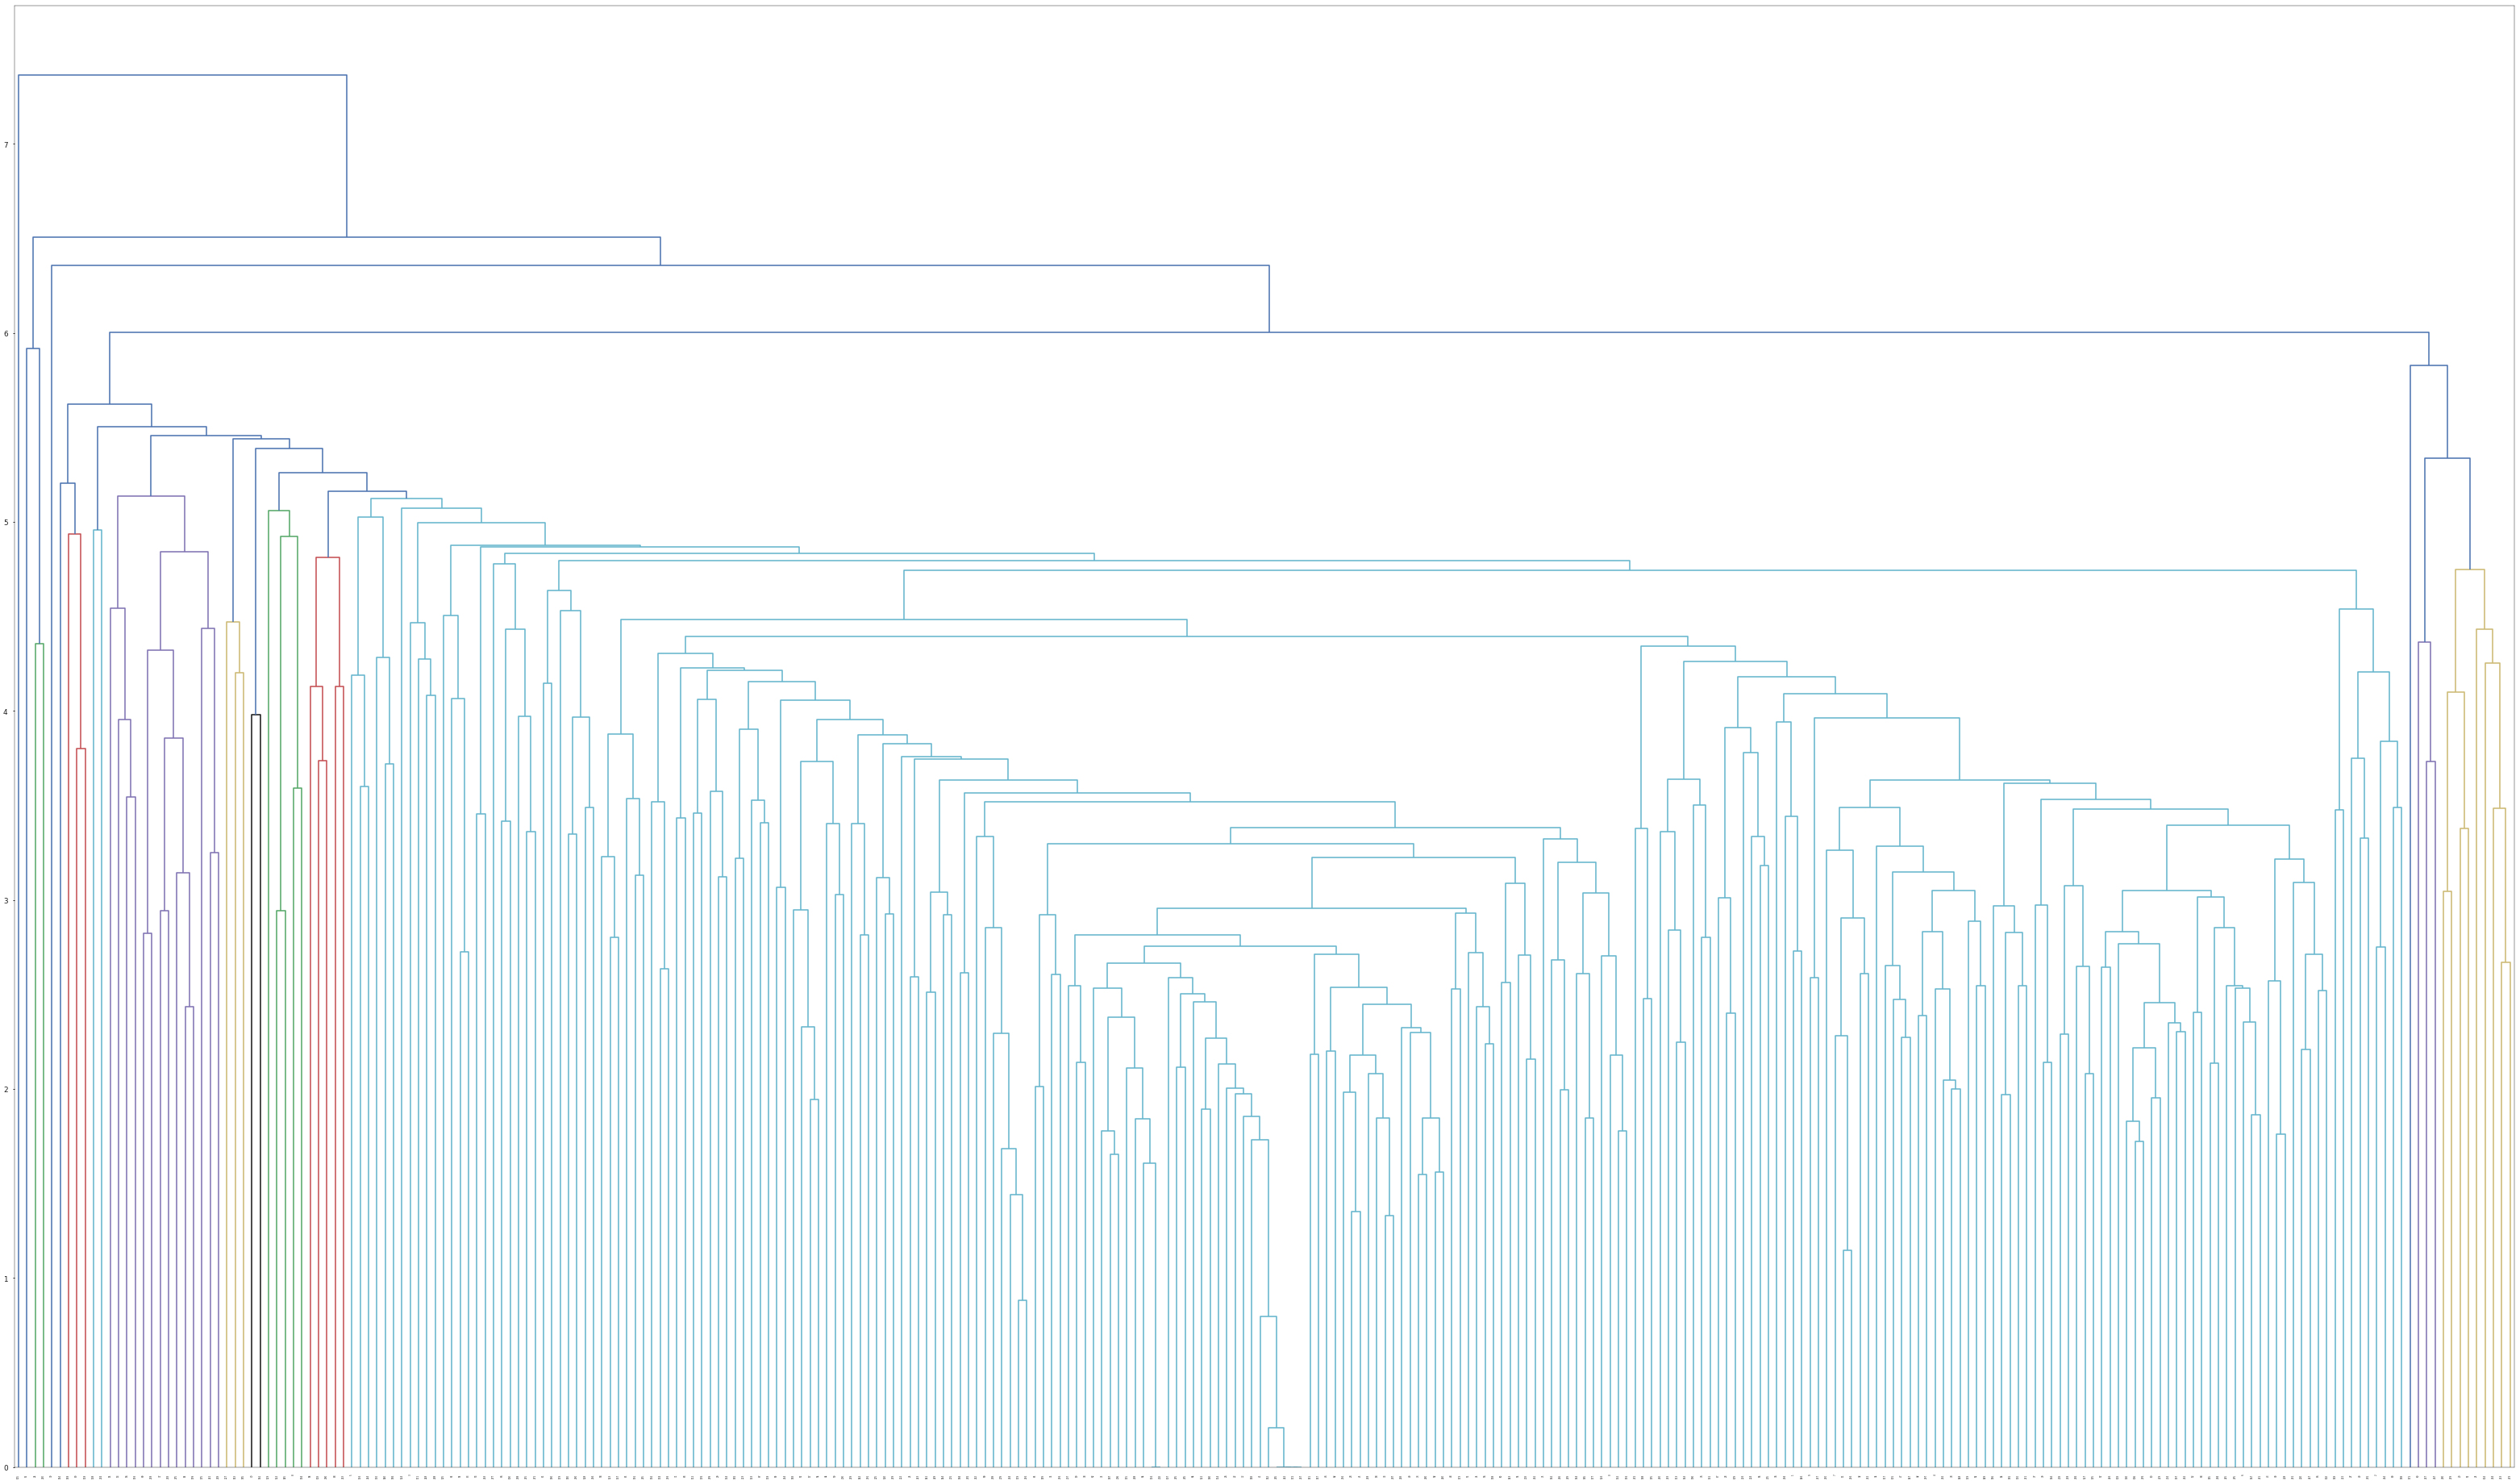

Squirrel's Nest,2655 State Rd 51,McFarland,WI
Players Sports Bar,2013 Winnebago St,Madison,WI
Hail Mary Sports Grill,401 E Washington Ave,Madison,WI
Paoli Pub & Grill,6893 Paoli Rd,Belleville,WI
Ski's Saloon,100 W Main St,Sun Prairie,WI
Manna Cafe & Bakery,611 N Sherman Ave,Madison,WI
Macchiatos Coffee & Wine Bar,605 S Main St,DeForest,WI
Sí Café,117 S Pinckney St,Madison,WI
Highland Espresso Bar,45 S Bassett St,Madison,WI
Village Bar,3801 Mineral Point Rd,Madison,WI
Jordan's Big Ten Pub,1330 Regent St,Madison,WI
Surya Cafe,5500 E Cheryl Pkwy, Ste 101,Fitchburg,WI
North and South Seafood & Smokehouse,605 S Main St,DeForest,WI
Growlers To Go-Go,2927 E Washington Ave,Madison,WI
Cambridge Winery - Madison Tasting Room,1001 S Whitney Way,Madison,WI
Salted Root Coffee House,11 N Allen St,Madison,WI
Leia's Lunchbox,44 E Mifflin St,Madison,WI
Madison Food Explorers,2406 Upham St,Madison,WI
PaintBar Madison,1224 Williamson St,Madison,WI
Hit Ratio:  0.818181818182
NDCG:  0.841339217752





Rec

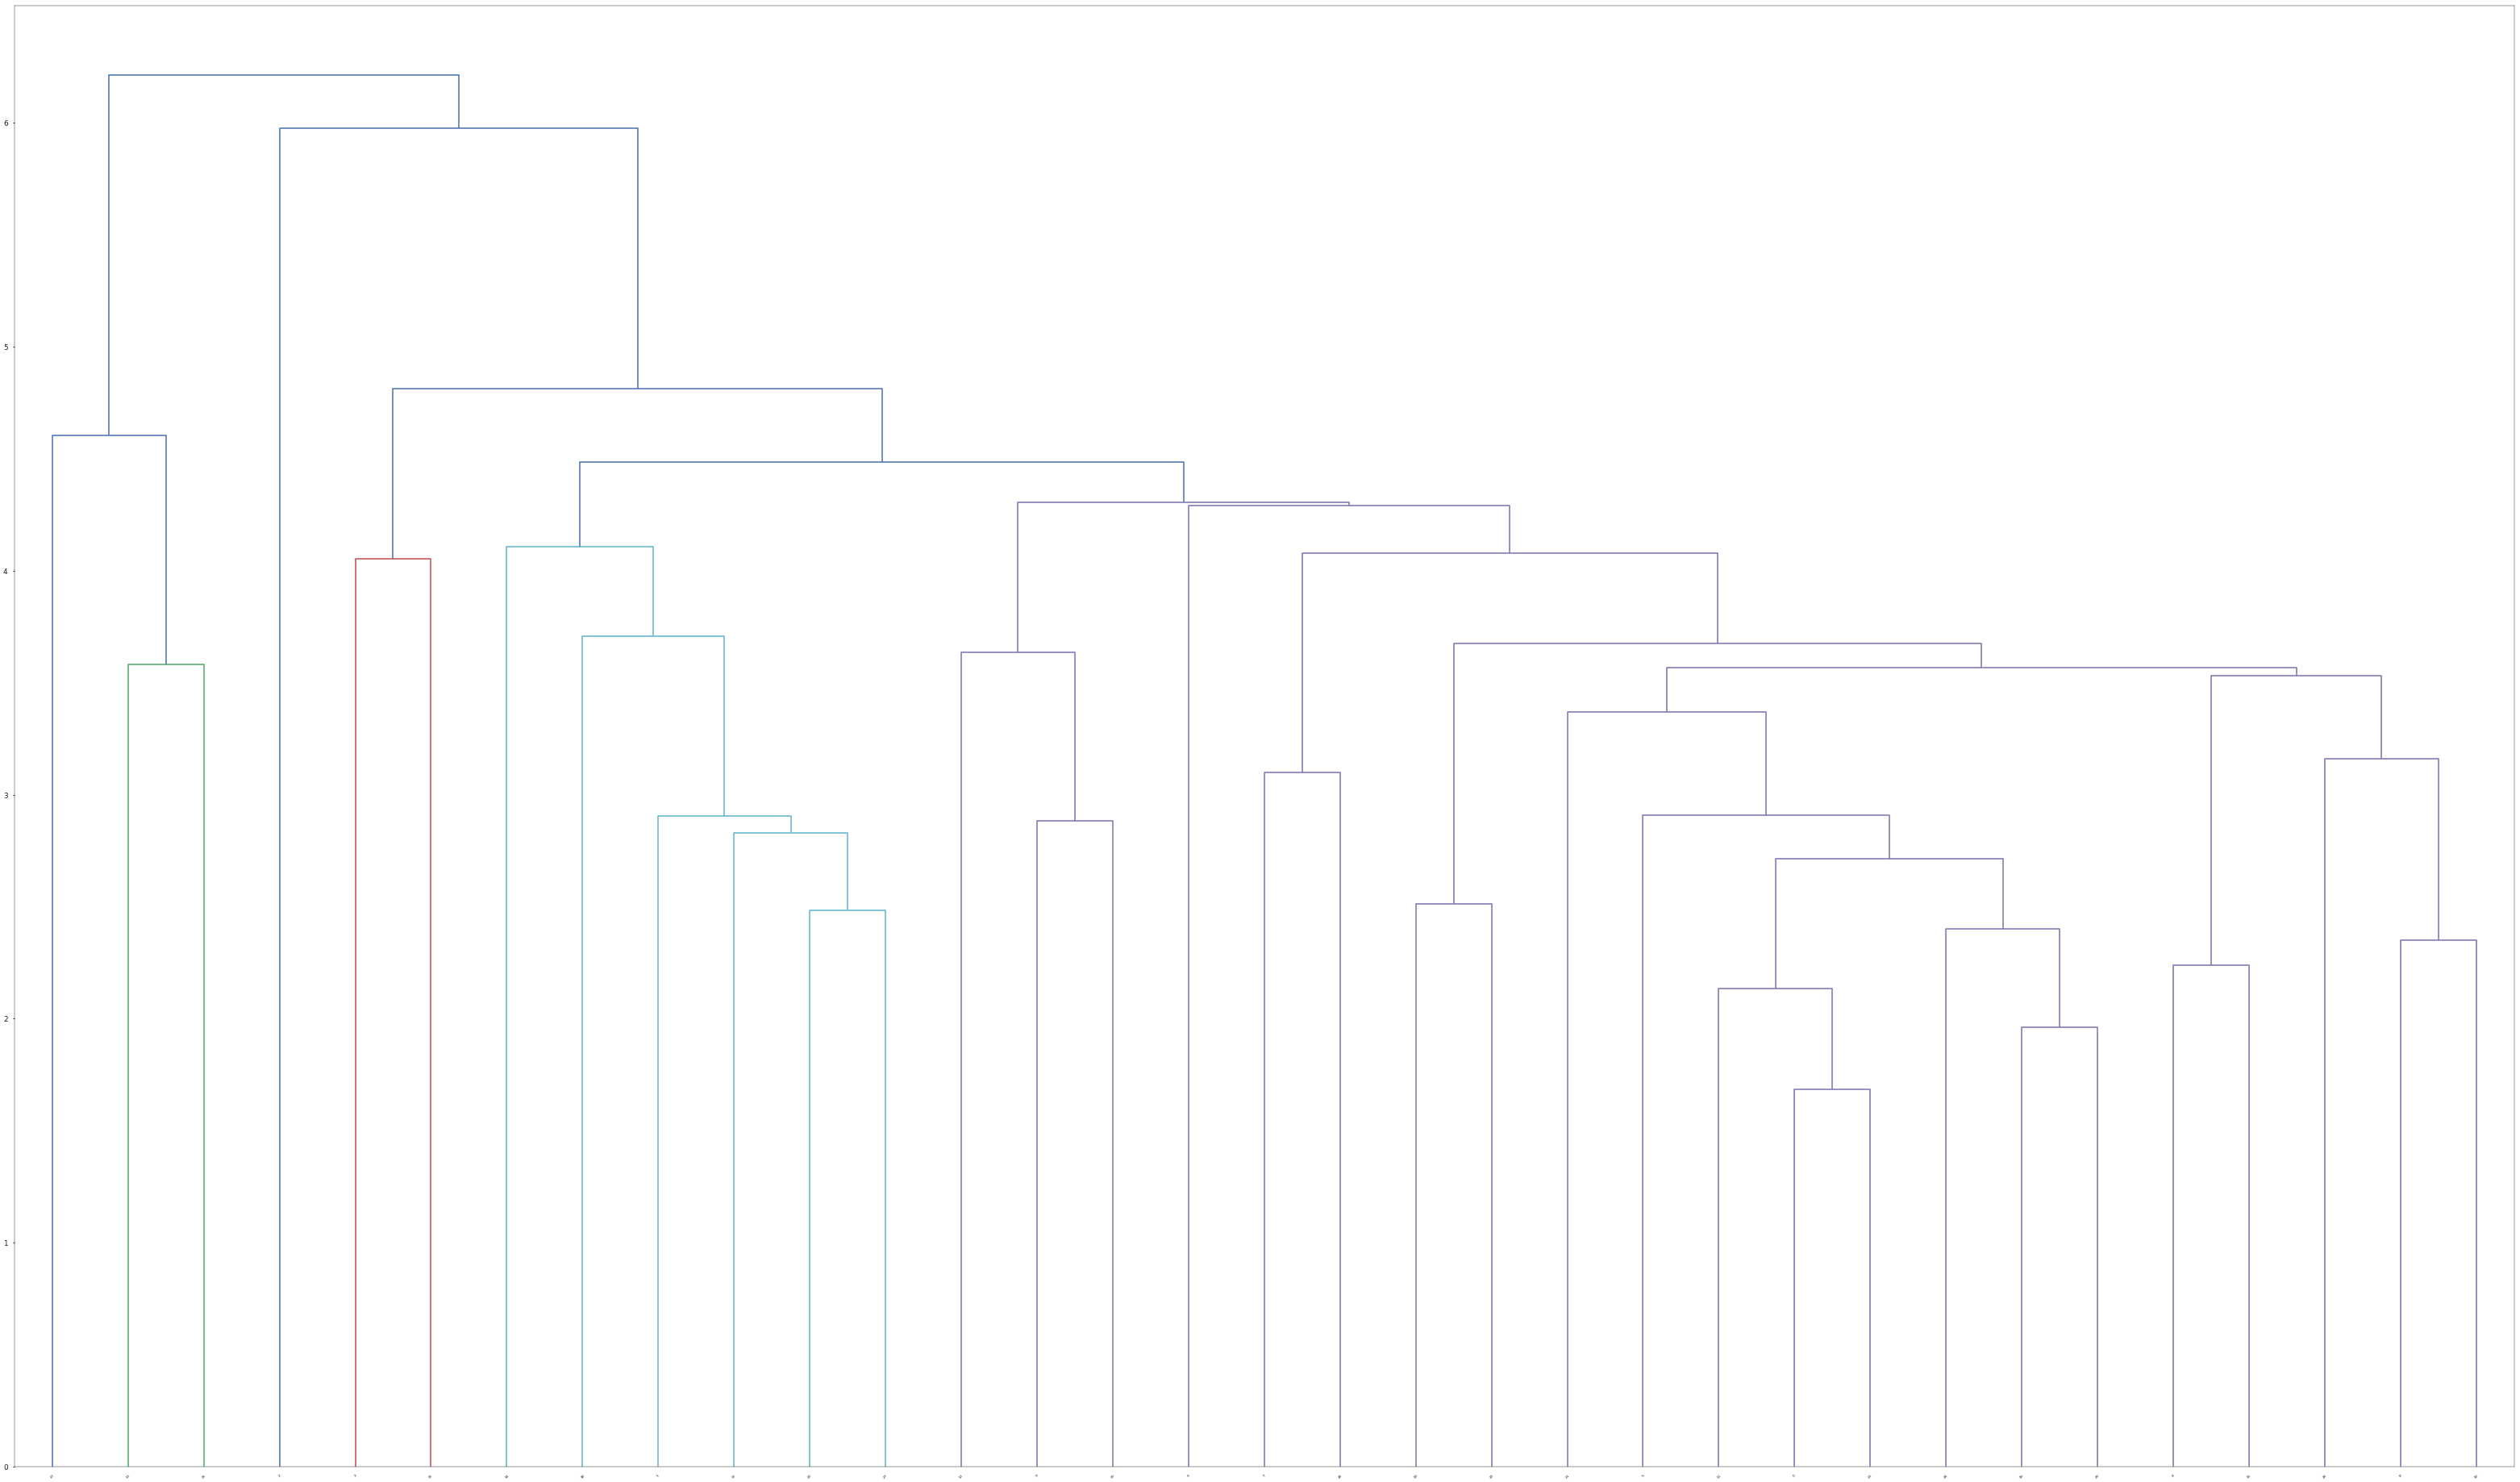

Mögle,Dieterlestr. 32,Stuttgart,BW
El Camino,Marbacher Str. 18,Stuttgart,BW
Wein-Musketier,Julius-Hölder-Str. 29 B,Stuttgart,BW
Hotel Restaurant Hirsch,Hindenburgstr. 1,Leonberg,BW
Orra Dönerlounge,fleischmannstr. 10,Esslingen,BW
Bar Vicino,Traubenstr. 45,Stuttgart,BW
Weinstube Am Stadtgraben,Am Stadtgraben 6,Stuttgart,BW
Délice,Hauptstätter Str. 61,Stuttgart,BW
Aldinger's Restaurant,Schmerstr. 6,Fellbach,BW
BO'TECA di vino,Beethovenstr. 30,Stuttgart,BW
Buschpilot,Karl-Schurz-Str. 28 C,Stuttgart,BW
Weinstube Vetter,Bopserstr. 18,Stuttgart,BW
Cafe Pause,Esslinger Str. 26,Ostfildern,BW
Ulmers Besenwirtschaft,Langobardenstr. 30,Stuttgart,BW
Weinstube zum Tröpfle,Zabergäustr. 73,Stuttgart,BW
Da Enzo Ristorante E Pizzeria,Im Dietbach 3,Fellbach,BW
Malathounis,Gartenstr. 5,Kernen im Remstal,BW
Knausbira Stüble,Heumadener Str. 15,Stuttgart,BW
Weinstube Viertelesschlotzer,Forststr. 57,Stuttgart,BW
Hit Ratio:  1.0
NDCG:  0.8





Recommendation info summary for :  IL
number of valid user:  107


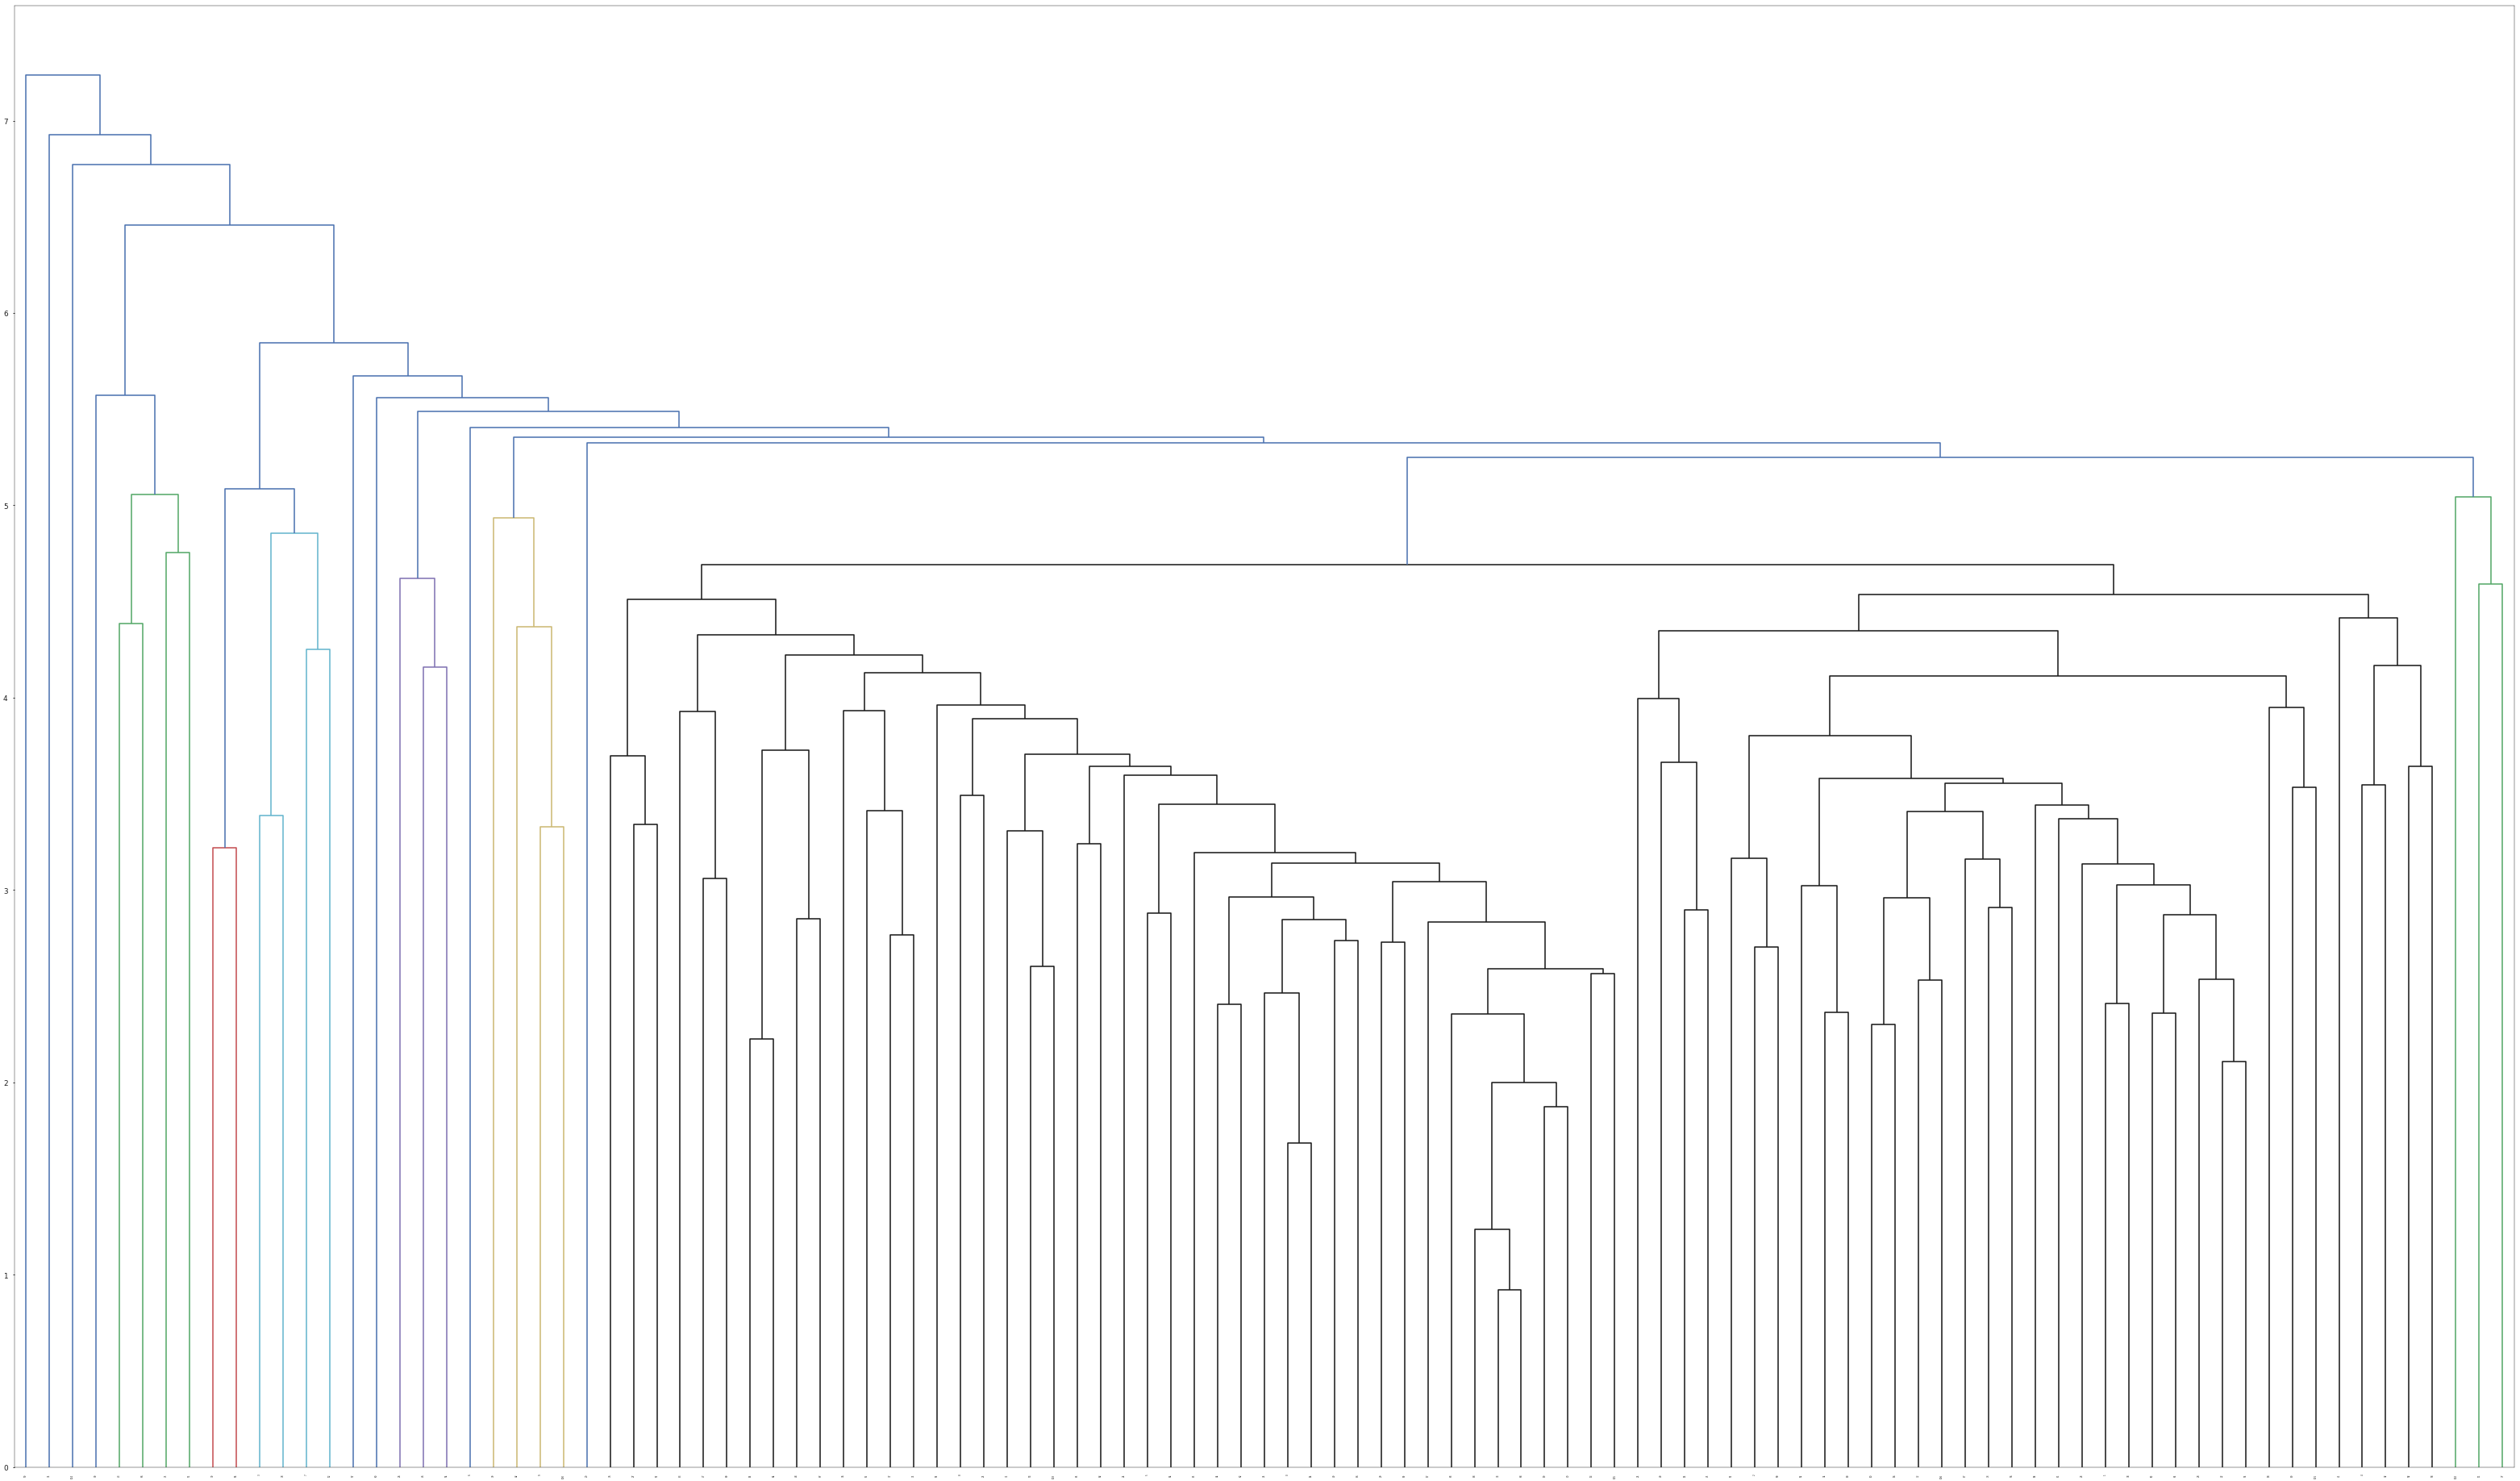

Wines At the Pines,2860 S Philo Rd, Ste L,Urbana,IL
JP Cool's Bar & Grill,14 N Jefferson St,Mansfield,IL
Rantoul Public House,108 N Garrard St,Rantoul,IL
Hybrid Fit Food,410 East University Ave, Ste 101,Champaign,IL
Casa Real,1204 Bear Ln,Monticello,IL
Flyght Bar and Lounge,142 Lincoln Sq,Urbana,IL
Sun Singer Wine and Spirits,1115 W Windsor Rd,Champaign,IL
Esquire Lounge,106 N Walnut St,Champaign,IL
V Picasso,122 N Neil St,Champaign,IL
Miga,301 N Neil St, Ste 104,Champaign,IL
Yori Q Korean Grill & Bar,715 S Neil St,Champaign,IL
Fat City Bar and Grill,505 S Chestnut St,Champaign,IL
Triptych Brewing,1703 Woodfield Dr,Savoy,IL
Project 47,608 E Main St,Mahomet,IL
The Brown Bag Deli Restaurant,212 W Washington St,Monticello,IL
Main Street Belly Deli,118 S Main St,Homer,IL
Pie's the Limit,2510 Village Green Pl,Champaign,IL
Dragon Fire Pizza,,Champaign,IL
Uncle Martin's Sports Bar,1104 N Cunningham Ave,Urbana,IL
Hit Ratio:  0.56
NDCG:  0.791209716721







In [ ]:
hr_list = []
ndcg_list = []
for state in valid_state:
    result = recommend_based_on_state(state)
    hr_list.append(result[0])
    ndcg_list.append(result[1])

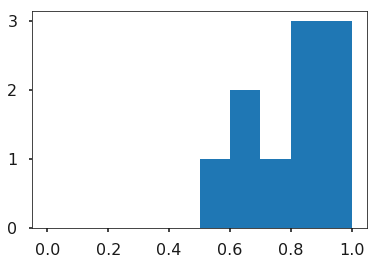

In [ ]:
plt.hist([x for x in hr_list if not np.isnan(x)], bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

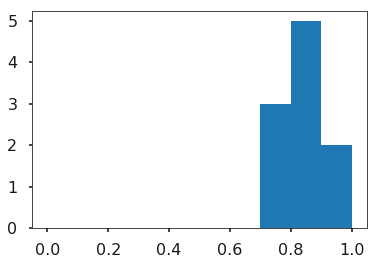

In [ ]:
plt.hist([x for x in ndcg_list if not np.isnan(x)], bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

In [ ]:
print("Average Hit ratio is : \n", statistics.mean(hr_list))

print("Average NDCG is : \n", statistics.mean(ndcg_list))


Average Hit ratio is : 
 0.786498718744
Average NDCG is : 
 0.846579499616
